<a href="https://colab.research.google.com/github/cl0udy322322-crypto/project3/blob/main/(%EC%BD%94%EC%8A%A4%ED%94%BC_200%EC%A2%85%EB%AA%A9)_%EA%B8%B0%EC%88%A0%EC%A0%81_%EB%B6%84%EC%84%9D_%EC%95%8C%ED%8C%8C_%EC%B0%BE%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 0. 환경 설치
!pip install -q finance-datareader pandas numpy scipy matplotlib seaborn scikit-learn statsmodels ta-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.7 MB/s eta 0:00:00


In [ ]:
# STEP 2. 코스피200 유니버스 로드 (기준일 고정)
universe = pd.read_csv(
    "/content/코스피 200 종목 리스트.csv",
    encoding="cp949"
)

universe["종목코드"] = universe["종목코드"].astype(str).str.zfill(6)
tickers = universe["종목코드"].tolist()


In [ ]:
# STEP 3. 가격 데이터 수집 (10년)
START, END = "2016-01-01", "2025-12-31"

price_data = {}
for code in tickers:
    try:
        df = fdr.DataReader(code, START, END)
        price_data[code] = df[["Open","High","Low","Close","Volume"]]
    except:
        pass


In [ ]:
dfs = []

for code, df in price_data.items():
    tmp = df.copy()
    tmp["Ticker"] = code
    dfs.append(tmp)

price_df = (
    pd.concat(dfs)
    .reset_index()
    .set_index(["Date","Ticker"])
    .sort_index()
)

# 상장 이후 데이터만 사용
price_df = price_df[price_df["Close"].notna()]


In [ ]:
# 가격 데이터 정합성 필터링
price_df = price_df.sort_index()

# 1) 종가 없는 날 제거 (상장 전 / API 오류)
price_df = price_df[price_df["Close"].notna()]

# 2) 거래 정지일 제거 (선택)
price_df = price_df[price_df["Volume"] > 0]


STEP 5. 기본 시계열 준비 (과거 데이터만)

In [ ]:
close  = price_df["Close"]
high   = price_df["High"]
low    = price_df["Low"]
volume = price_df["Volume"]

ret_1d = close.groupby(level=1).pct_change()


Forward Return

In [ ]:
future_ret = (
    close
    .groupby(level="Ticker")
    .pct_change()
    .shift(-1)
)


20개 팩터 생성

In [ ]:
factor_groups = {
    "momentum": ["mom_1m", "mom_3m", "mom_6m", "mom_12m", "ret_5d"],
    "trend": ["ma_gap_20", "ma_gap_60", "ma_slope_20", "ma_slope_60", "price_z_60"],
    "volatility": ["vol_1m", "vol_3m", "vol_6m", "range_20", "atr_20"],
    "volume": ["vol_z", "vol_mom_20", "turnover_20", "dollar_vol_z", "volume_trend_20"],
}


In [ ]:
import talib

# 각 종목별로 MACD 계산 (MACD, MACD_signal, Hist)
def compute_macd(group):
    macd, signal, hist = talib.MACD(group['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    group['MACD'] = macd
    group['MACD_signal'] = signal
    return group

# `apply`를 사용하여 각 그룹별로 MACD 계산
price_df = price_df.groupby('Ticker').apply(compute_macd)

# 이제 price_df에 'MACD'와 'MACD_signal'이 추가됩니다.


In [ ]:
import pandas as pd
import FinanceDataReader as fdr
import talib

# KOSPI 200 종목 리스트를 CSV로부터 불러오기
universe = pd.read_csv("/content/코스피 200 종목 리스트.csv", encoding="cp949")
universe["종목코드"] = universe["종목코드"].astype(str).str.zfill(6)  # 종목 코드 6자리로 맞추기
tickers = universe["종목코드"].tolist()

# 가격 데이터를 수집하는 구간
START, END = "2016-01-01", "2025-12-31"
price_data = {}

# 각 종목의 가격 데이터를 가져오기
for code in tickers:
    try:
        df = fdr.DataReader(code, START, END)
        price_data[code] = df[["Open", "High", "Low", "Close", "Volume"]]
    except:
        pass

# 종목별 데이터 병합
dfs = []
for code, df in price_data.items():
    tmp = df.copy()
    tmp["Ticker"] = code
    dfs.append(tmp)

price_df = pd.concat(dfs).reset_index().set_index(["Date", "Ticker"]).sort_index()
price_df = price_df[price_df["Close"].notna()]  # 상장 이후 데이터만 사용

# 각 종목별로 MACD 계산 (MACD, MACD_signal, Hist)
def compute_macd(group):
    macd, signal, hist = talib.MACD(group['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    group['MACD'] = macd
    group['MACD_signal'] = signal
    return group

# `apply`를 사용하여 각 그룹별로 MACD 계산
price_df = price_df.groupby('Ticker').apply(compute_macd)

# 20개 기술적 지표 예시 (이것은 예시로 몇 개만 나열합니다)
price_df['SMA_20'] = price_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
price_df['SMA_200'] = price_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=200).mean())
price_df['RSI_14'] = price_df.groupby('Ticker')['Close'].transform(lambda x: talib.RSI(x, timeperiod=14))

# 그 외 16개 지표를 추가적으로 생성할 수 있습니다.
# 예시 지표들을 생성했다고 가정

# 팩터 생성 직후 결측치 처리
factor_cols = [
    'SMA_20', 'SMA_200', 'RSI_14', 'MACD_signal',  # 예시 지표
    'MACD'  # 추가된 MACD 지표
]

# 팩터 생성 직후 결측치 제거
price_df = price_df.dropna(subset=factor_cols)  # 팩터에 결측치가 있는 행을 제거

# 최종적으로 모델링에 사용할 데이터셋을 얻음


미래 수익률 정의 (지표 검증용)

In [ ]:
fwd_ret = (
    close.groupby(level=1)
    .pct_change(21)
    .shift(-21)
)


팩터 → IC 시계열 계산 함수

In [ ]:
def calc_ic_ts(factor, fwd_ret):
    return factor.groupby(level=0).corr(fwd_ret)


모든 팩터의 IC 시계열 만들기

In [ ]:
from joblib import Parallel, delayed

# 병렬로 IC 시계열 계산
def calc_ic_for_factor(factor, fwd_ret):
    return calc_ic_ts(factor, fwd_ret)

# 병렬 처리로 IC 시계열 계산
ic_ts_all = Parallel(n_jobs=-1)(delayed(calc_ic_for_factor)(factors[f], fwd_ret) for f in factor_list)

# 결과를 ic_ts_all에 저장
ic_ts_df = pd.DataFrame(ic_ts_all, index=factor_list)


팩터와 수익률을 한 번에 묶기

In [ ]:
factor_list = sum(factor_groups.values(), [])

data = pd.concat(
    [factors[factor_list], fwd_ret.rename("fwd_ret")],
    axis=1
).dropna()


날짜별 IC를 한 번에 계산

In [ ]:
def daily_ic(df):
    y = df["fwd_ret"]
    X = df.drop(columns="fwd_ret")
    return X.corrwith(y)

ic_ts_df = data.groupby(level=0).apply(daily_ic)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: Run

바로 히트맵으로 연결

In [ ]:
ic_corr = ic_ts_df.corr()


IC 상관관계 히트맵 (지표 선정의 핵심)

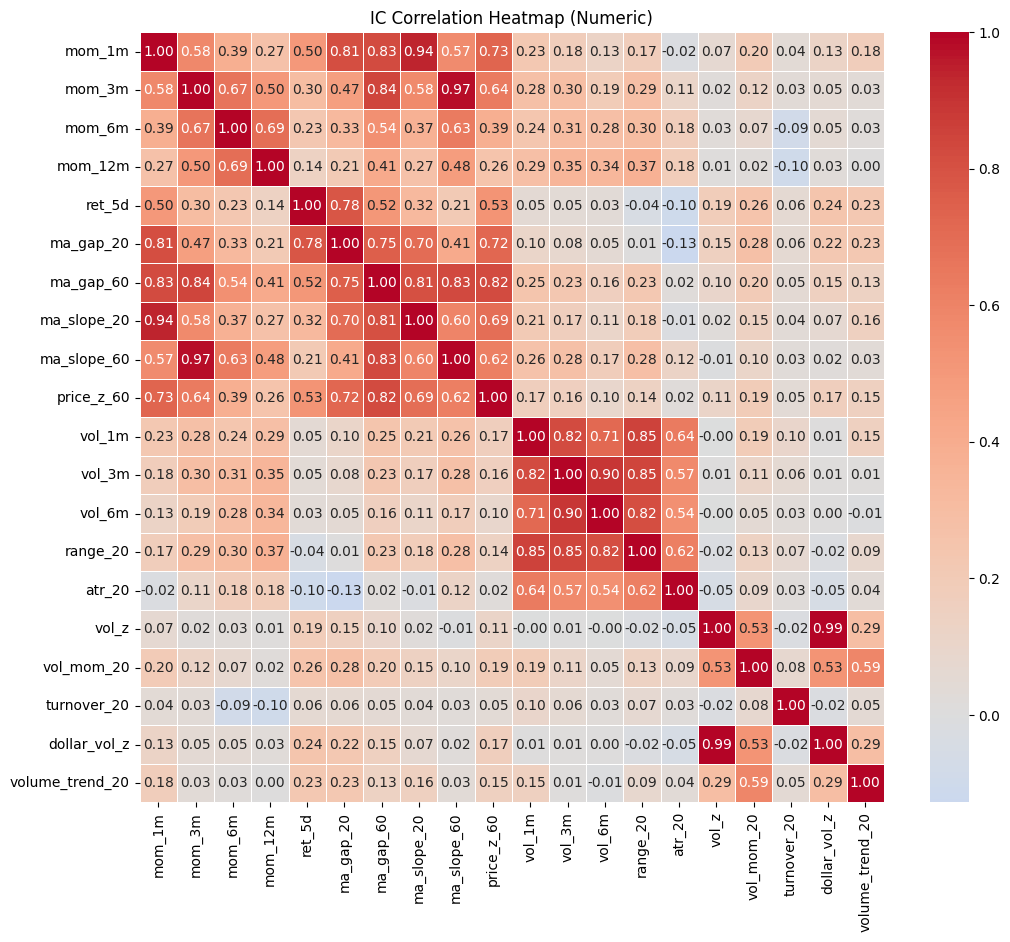

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ic_corr = ic_ts_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    ic_corr,
    annot=True,          # 🔥 숫자 표시
    fmt=".2f",           # 소수점 2자리
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar=True
)
plt.title("IC Correlation Heatmap (Numeric)")
plt.show()


히트맵 기반

In [ ]:
selected_factors = [
    "price_z_60",       # 위치 (밸류/과열 회피)
    "mom_12m",          # 장기 방향성
    "atr_20",           # 변동성 (낮을수록 좋음)
    "volume_trend_20"   # 수급 지속성
]


숫자 히트맵

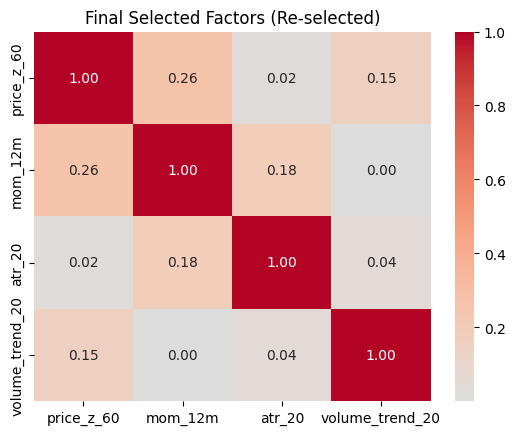

In [ ]:
sns.heatmap(
    ic_ts_df[selected_factors].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Final Selected Factors (Re-selected)")
plt.show()


지금 히트맵 수치 해석 (팩트 기반)

price_z_60
mom_12m
atr_20
volume_trend_20


| 쌍                            | IC 상관    |
| ---------------------------- | -------- |
| price_z_60 ↔ mom_12m         | **0.26** |
| price_z_60 ↔ atr_20          | **0.02** |
| price_z_60 ↔ volume_trend_20 | **0.15** |
| mom_12m ↔ atr_20             | **0.18** |
| mom_12m ↔ volume_trend_20    | **0.00** |
| atr_20 ↔ volume_trend_20     | **0.04** |


마지막 검증 (숫자 히트맵)

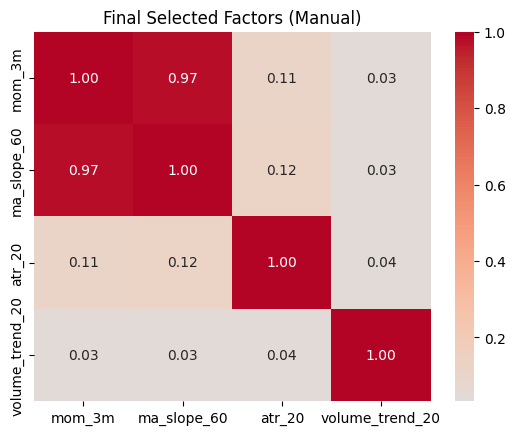

In [ ]:
sns.heatmap(
    ic_ts_df[selected_factors].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Final Selected Factors (Manual)")
plt.show()


In [ ]:
# 1. 기준일 선택 (권장)
dates = factors.index.get_level_values(0).unique()
T0 = dates[-252]   # 1년 전 기준

# 2. 팩터 스냅샷
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

snapshot = factors.loc[T0, selected_factors].dropna()

# 3. 방향 보정
snapshot = snapshot.copy()
snapshot["atr_20"] = -snapshot["atr_20"]

# 4. 횡단면 표준화
z = (snapshot - snapshot.mean()) / snapshot.std()
alpha_score = z.mean(axis=1)

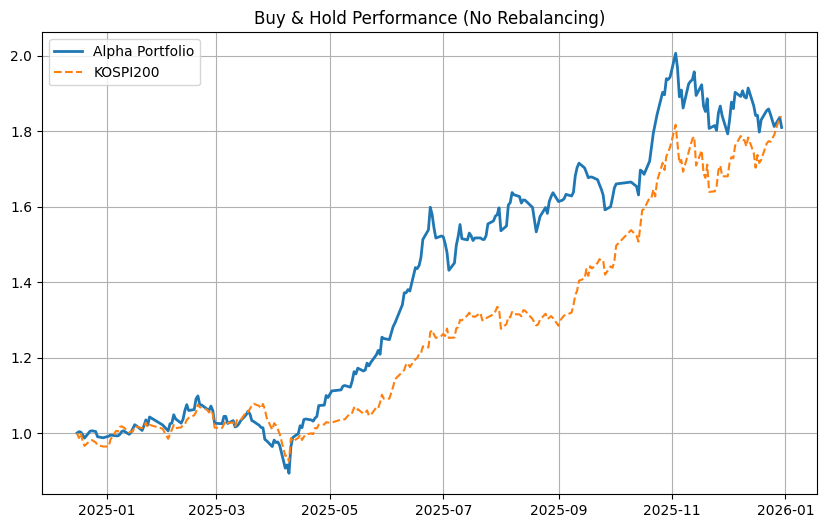

=== Performance Summary ===
          Total Return       MDD
Alpha         0.810120 -0.186770
KOSPI200      0.838476 -0.142604


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr # Import FinanceDataReader

# =========================
# 0. 최종 선택된 팩터 (고정)
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

# =========================
# 1. 기준일(T0) 설정
# =========================
dates = factors.index.get_level_values(0).unique()
T0 = dates[-252]   # 1년 전 기준

# =========================
# 2. 기준일 팩터 스냅샷
# =========================
snapshot = factors.loc[T0, selected_factors].dropna()

# =========================
# 3. 팩터 방향 보정
# =========================
snapshot = snapshot.copy()
snapshot["atr_20"] = -snapshot["atr_20"]  # 변동성은 낮을수록 좋게

# =========================
# 4. 횡단면 표준화 (z-score)
# =========================
z = (snapshot - snapshot.mean()) / snapshot.std()

# =========================
# 5. 알파 스코어 계산
# =========================
alpha_score = z.mean(axis=1)
alpha_score.name = "alpha"

# =========================
# 6. 종목 선택 (Top N)
# =========================
N = 20
selected_tickers = (
    alpha_score
    .sort_values(ascending=False)
    .head(N)
    .index
)

# =========================
# 7. Buy & Hold 수익률
# =========================
price_sel = close.loc[(slice(T0, None), selected_tickers)]
price_sel = price_sel.unstack("Ticker")

cum_ret = price_sel / price_sel.iloc[0]
portfolio_ret = cum_ret.mean(axis=1)

# =========================
# 8. KOSPI200 수익률
# =========================
# Load KOSPI200 data
kospi200 = fdr.DataReader("KS200", START, END)["Close"]
kospi_cum = kospi200.loc[T0:] / kospi200.loc[T0]

# =========================
# 9. 성과 시각화
# =========================
plt.figure(figsize=(10, 6))
plt.plot(portfolio_ret, label="Alpha Portfolio", linewidth=2)
plt.plot(kospi_cum, label="KOSPI200", linestyle="--")
plt.legend()
plt.title("Buy & Hold Performance (No Rebalancing)")
plt.grid(True)
plt.show()

# =========================
# 10. MDD 계산 함수
# =========================
def max_drawdown(series):
    cum_max = series.cummax()
    drawdown = series / cum_max - 1
    return drawdown.min()

mdd_alpha = max_drawdown(portfolio_ret)
mdd_kospi = max_drawdown(kospi_cum)

# =========================
# 11. 결과 요약
# =========================
result = pd.DataFrame({
    "Total Return": [
        portfolio_ret.iloc[-1] - 1,
        kospi_cum.iloc[-1] - 1
    ],
    "MDD": [
        mdd_alpha,
        mdd_kospi
    ]
}, index=["Alpha", "KOSPI200"])

print("=== Performance Summary ===")
print(result)

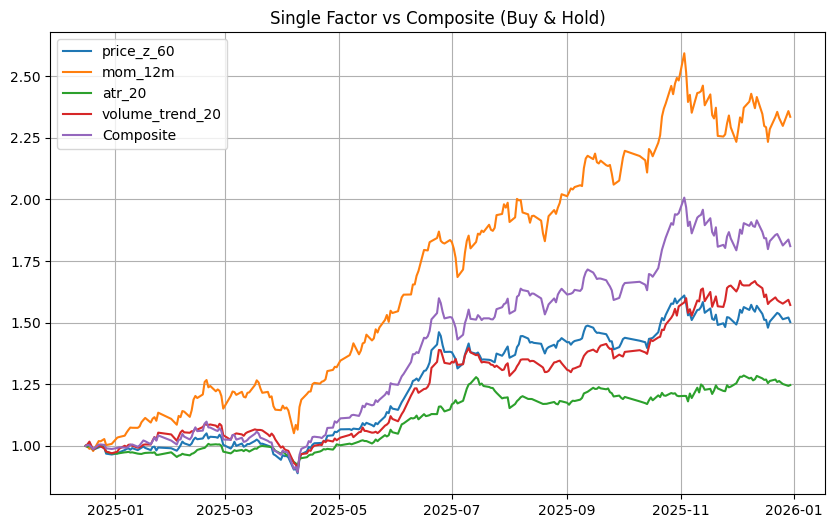

,Total Return,MDD
Portfolio,,
price_z_60,0.502078,-0.154023
mom_12m,1.334716,-0.170321
atr_20,0.246619,-0.098145
volume_trend_20,0.571491,-0.176973
Composite,0.810120,-0.186770


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0. 설정
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

dates = factors.index.get_level_values(0).unique()
T0 = dates[-252]      # 1년 전
N = 20                # 동일 종목 수

# =========================
# 1. 기준일 스냅샷
# =========================
snapshot = factors.loc[T0, selected_factors].dropna()
snapshot = snapshot.copy()
snapshot["atr_20"] = -snapshot["atr_20"]  # 변동성 방향 보정

# =========================
# 2. 횡단면 표준화
# =========================
z = (snapshot - snapshot.mean()) / snapshot.std()

# =========================
# 3. 포트폴리오 생성 함수
# =========================
def build_portfolio(score, name):
    tickers = score.sort_values(ascending=False).head(N).index

    prices = close.loc[(slice(T0, None), tickers)]
    prices = prices.unstack("Ticker")

    cum_ret = prices / prices.iloc[0]
    port_ret = cum_ret.mean(axis=1)
    port_ret.name = name
    return port_ret

# =========================
# 4. 단독 팩터 포트폴리오
# =========================
portfolio_dict = {}

for f in selected_factors:
    portfolio_dict[f] = build_portfolio(z[f], f)

# =========================
# 5. 결합 팩터 포트폴리오
# =========================
composite_score = z.mean(axis=1)
portfolio_dict["Composite"] = build_portfolio(composite_score, "Composite")

# =========================
# 6. 누적 수익률 비교
# =========================
plt.figure(figsize=(10, 6))

for name, series in portfolio_dict.items():
    plt.plot(series, label=name)

plt.legend()
plt.title("Single Factor vs Composite (Buy & Hold)")
plt.grid(True)
plt.show()

# =========================
# 7. MDD 계산
# =========================
def max_drawdown(series):
    cum_max = series.cummax()
    dd = series / cum_max - 1
    return dd.min()

# =========================
# 8. 성과 요약 테이블
# =========================
summary = []

for name, series in portfolio_dict.items():
    summary.append({
        "Portfolio": name,
        "Total Return": series.iloc[-1] - 1,
        "MDD": max_drawdown(series)
    })

summary_df = pd.DataFrame(summary).set_index("Portfolio")
summary_df


In [ ]:
alpha_score.head()


,alpha
Ticker,
000080,0.259665
000100,0.181619
000120,-0.513470
000150,1.626201
000210,-0.560599


In [ ]:
check = (
    z["price_z_60"]
    + z["mom_12m"]
    + z["atr_20"]
    + z["volume_trend_20"]
) / 4

(np.allclose(alpha_score.values, check.values))


True

10년 비교 올인원 코드 (팩터 결합 vs KOSPI200)

In [ ]:
import pandas as pd
import numpy as np

# =========================
# 0. 설정
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

N = 20
dates = factors.index.get_level_values(0).unique()

# 🔥 데이터 길이에 맞게 수정
start_idx = 252 * 5   # 5년

# =========================
# 1. price index-safe 변환
# =========================
price_panel = close.unstack("Ticker")  # index=Date, columns=Ticker

# =========================
# 2. 결과 저장용
# =========================
alpha_path = []
kospi_path = []

# =========================
# 3. 워크포워드 루프
# =========================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # --- 팩터 스냅샷
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)

    tickers = alpha_score.sort_values(ascending=False).head(N).index

    # --- 가격 (index-safe)
    if T0 not in price_panel.index or T1 not in price_panel.index:
        continue

    price_T0 = price_panel.loc[T0, tickers]
    price_T1 = price_panel.loc[T1, tickers]

    common = price_T0.dropna().index.intersection(price_T1.dropna().index)
    if len(common) == 0:
        continue

    ret = price_T1.loc[common] / price_T0.loc[common] - 1
    alpha_path.append(ret.mean())

    # --- KOSPI200
    if T0 in kospi200.index and T1 in kospi200.index:
        kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

# =========================
# 4. 누적 성과
# =========================
alpha_curve = (1 + pd.Series(alpha_path)).cumprod()
kospi_curve = (1 + pd.Series(kospi_path)).cumprod()


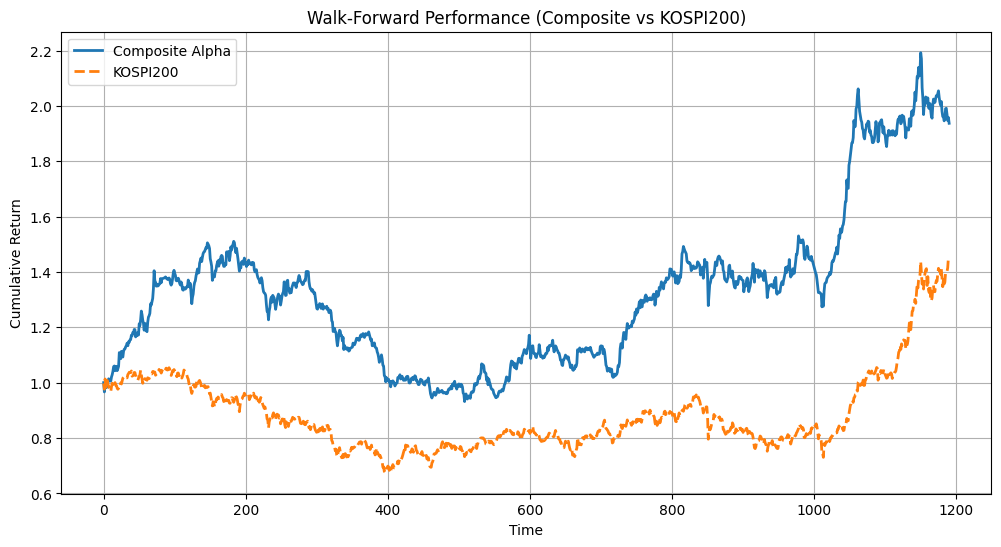

In [ ]:
import matplotlib.pyplot as plt

# 혹시 비어 있으면 중단
if len(alpha_curve) == 0 or len(kospi_curve) == 0:
    raise ValueError("alpha_curve 또는 kospi_curve가 비어 있습니다.")

plt.figure(figsize=(12, 6))

plt.plot(alpha_curve.values, label="Composite Alpha", linewidth=2)
plt.plot(kospi_curve.values, label="KOSPI200", linestyle="--", linewidth=2)

plt.legend()
plt.grid(True)
plt.title("Walk-Forward Performance (Composite vs KOSPI200)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")

# 🔥 핵심 3종 세트
plt.show()
plt.close()


✅ 최종 올인원 백테스트 코드

alpha_path len: 1191
kospi_path len: 1191


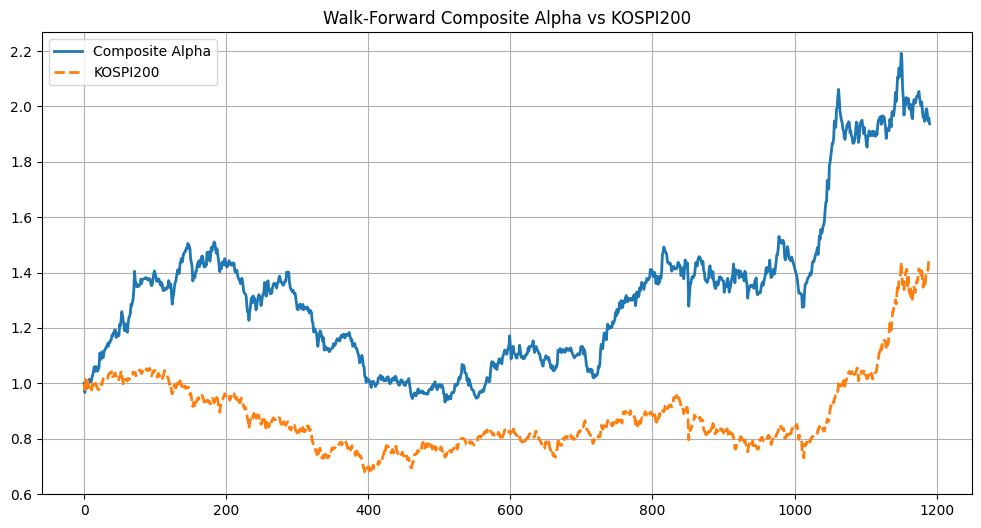


=== Performance Summary ===
                 Total Return     CAGR       MDD  Volatility    Sharpe  \
Composite Alpha      0.937272  0.15018 -0.383068    0.201084  0.796468   
KOSPI200             0.453608  0.08236 -0.361126    0.193425  0.506151   

                 Win Rate  
Composite Alpha  0.507976  
KOSPI200         0.517212  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0. 설정
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

N = 20
dates = factors.index.get_level_values(0).unique()
start_idx = 252 * 5

# =========================
# 1. price를 Date x Ticker 형태로 강제 변환
# =========================
price_panel = close.unstack("Ticker")  # index=Date, columns=Ticker

# =========================
# 2. 결과 저장용
# =========================
alpha_path = []
kospi_path = []

# =========================
# 3. 워크포워드 백테스트
# =========================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # --- 팩터 스냅샷
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)

    tickers = alpha_score.sort_values(ascending=False).head(N).index

    # --- 가격 (index-safe)
    if T0 not in price_panel.index or T1 not in price_panel.index:
        continue

    price_T0 = price_panel.loc[T0, tickers]
    price_T1 = price_panel.loc[T1, tickers]

    common = price_T0.dropna().index.intersection(price_T1.dropna().index)
    if len(common) == 0:
        continue

    ret = price_T1.loc[common] / price_T0.loc[common] - 1
    alpha_path.append(ret.mean())

    # --- KOSPI200
    if T0 in kospi200.index and T1 in kospi200.index:
        kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

print("alpha_path len:", len(alpha_path))
print("kospi_path len:", len(kospi_path))

# =========================
# 4. 누적 수익률
# =========================
alpha_ret = pd.Series(alpha_path)
kospi_ret = pd.Series(kospi_path)

alpha_curve = (1 + alpha_ret).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()

# =========================
# 5. 그래프
# =========================
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve.values, label="Composite Alpha", linewidth=2)
plt.plot(kospi_curve.values, label="KOSPI200", linestyle="--", linewidth=2)
plt.legend()
plt.grid(True)
plt.title("Walk-Forward Composite Alpha vs KOSPI200")
plt.show()

# =========================
# 6. 성과 지표
# =========================
def max_drawdown(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve, periods=252):
    years = len(curve) / periods
    return curve.iloc[-1] ** (1 / years) - 1

def summary(ret, curve):
    return {
        "Total Return": curve.iloc[-1] - 1,
        "CAGR": cagr(curve),
        "MDD": max_drawdown(curve),
        "Volatility": ret.std() * np.sqrt(252),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Win Rate": (ret > 0).mean()
    }

result = pd.DataFrame(
    [
        summary(alpha_ret, alpha_curve),
        summary(kospi_ret, kospi_curve)
    ],
    index=["Composite Alpha", "KOSPI200"]
)

print("\n=== Performance Summary ===")
print(result)


In [ ]:
import numpy as np
import pandas as pd

def max_drawdown(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve, periods=252):
    years = len(curve) / periods
    return curve.iloc[-1] ** (1 / years) - 1

def performance_table(ret, curve):
    return {
        "Total Return": curve.iloc[-1] - 1,
        "CAGR": cagr(curve),
        "MDD": max_drawdown(curve),
        "Volatility": ret.std() * np.sqrt(252),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Calmar": cagr(curve) / abs(max_drawdown(curve)),
        "Win Rate": (ret > 0).mean()
    }

summary_df = pd.DataFrame(
    [
        performance_table(alpha_ret, alpha_curve),
        performance_table(kospi_ret, kospi_curve)
    ],
    index=["Composite Alpha", "KOSPI200"]
)

summary_df


,Total Return,CAGR,MDD,Volatility,Sharpe,Calmar,Win Rate
Composite Alpha,0.937272,0.15018,-0.383068,0.201084,0.796468,0.392045,0.507976
KOSPI200,0.453608,0.08236,-0.361126,0.193425,0.506151,0.228064,0.517212


In [ ]:
alpha_year = alpha_ret.groupby(alpha_ret.index // 252).apply(lambda x: (1+x).prod()-1)
kospi_year = kospi_ret.groupby(kospi_ret.index // 252).apply(lambda x: (1+x).prod()-1)

yearly_df = pd.DataFrame({
    "Alpha": alpha_year.values,
    "KOSPI200": kospi_year.values
})

yearly_df


,Alpha,KOSPI200
0,0.313054,-0.132748
1,-0.242406,-0.115451
2,0.277497,0.123796
3,0.043833,-0.058905
4,0.460430,0.791674


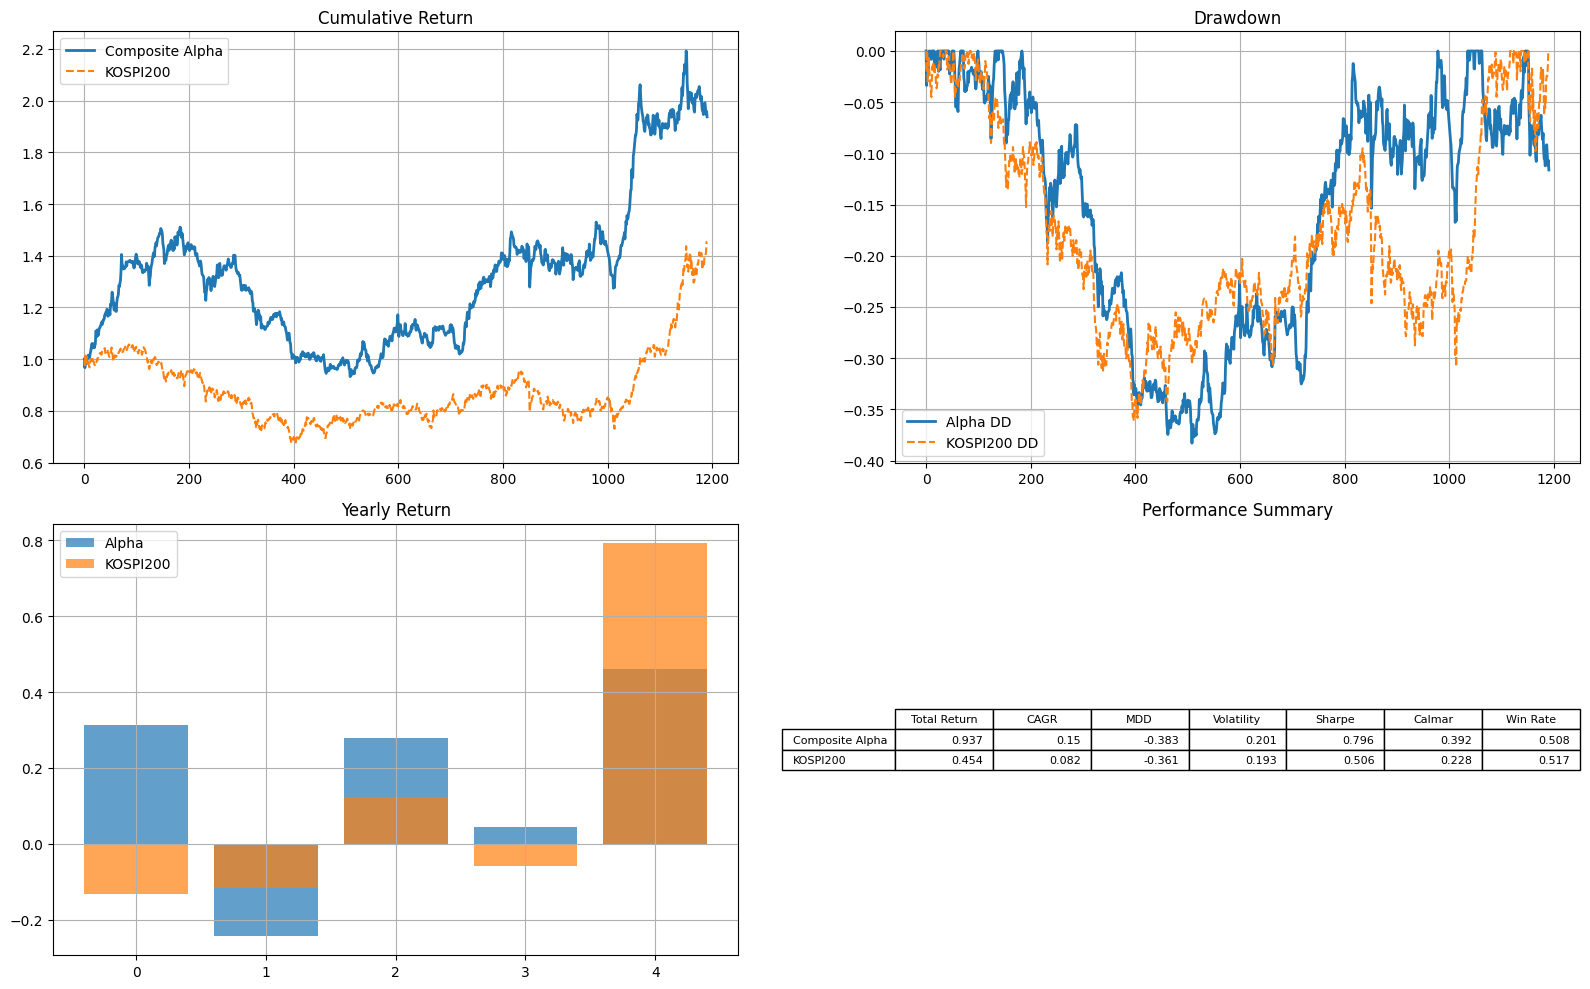

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# =========================
# (1) 누적 수익률
# =========================
plt.subplot(2, 2, 1)
plt.plot(alpha_curve.values, label="Composite Alpha", linewidth=2)
plt.plot(kospi_curve.values, label="KOSPI200", linestyle="--")
plt.title("Cumulative Return")
plt.legend()
plt.grid(True)

# =========================
# (2) Drawdown
# =========================
def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.subplot(2, 2, 2)
plt.plot(drawdown(alpha_curve).values, label="Alpha DD", linewidth=2)
plt.plot(drawdown(kospi_curve).values, label="KOSPI200 DD", linestyle="--")
plt.title("Drawdown")
plt.legend()
plt.grid(True)

# =========================
# (3) 연도별 성과
# =========================
plt.subplot(2, 2, 3)
plt.bar(np.arange(len(alpha_year)), alpha_year.values, alpha=0.7, label="Alpha")
plt.bar(np.arange(len(kospi_year)), kospi_year.values, alpha=0.7, label="KOSPI200")
plt.title("Yearly Return")
plt.legend()
plt.grid(True)

# =========================
# (4) 성과지표 표
# =========================
plt.subplot(2, 2, 4)
plt.axis("off")

table_data = summary_df.round(3).values
table_cols = summary_df.columns
table_rows = summary_df.index

plt.table(
    cellText=table_data,
    colLabels=table_cols,
    rowLabels=table_rows,
    loc="center"
)

plt.title("Performance Summary")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

window = 252  # 1년 롤링 (표준)

# -------------------------
# Rolling Sharpe
# -------------------------
rolling_sharpe_alpha = (
    alpha_ret.rolling(window).mean() /
    alpha_ret.rolling(window).std()
) * np.sqrt(252)

rolling_sharpe_kospi = (
    kospi_ret.rolling(window).mean() /
    kospi_ret.rolling(window).std()
) * np.sqrt(252)

# -------------------------
# Rolling Alpha (연환산)
# -------------------------
rolling_alpha = (
    (alpha_ret - kospi_ret)
    .rolling(window)
    .mean()
) * 252


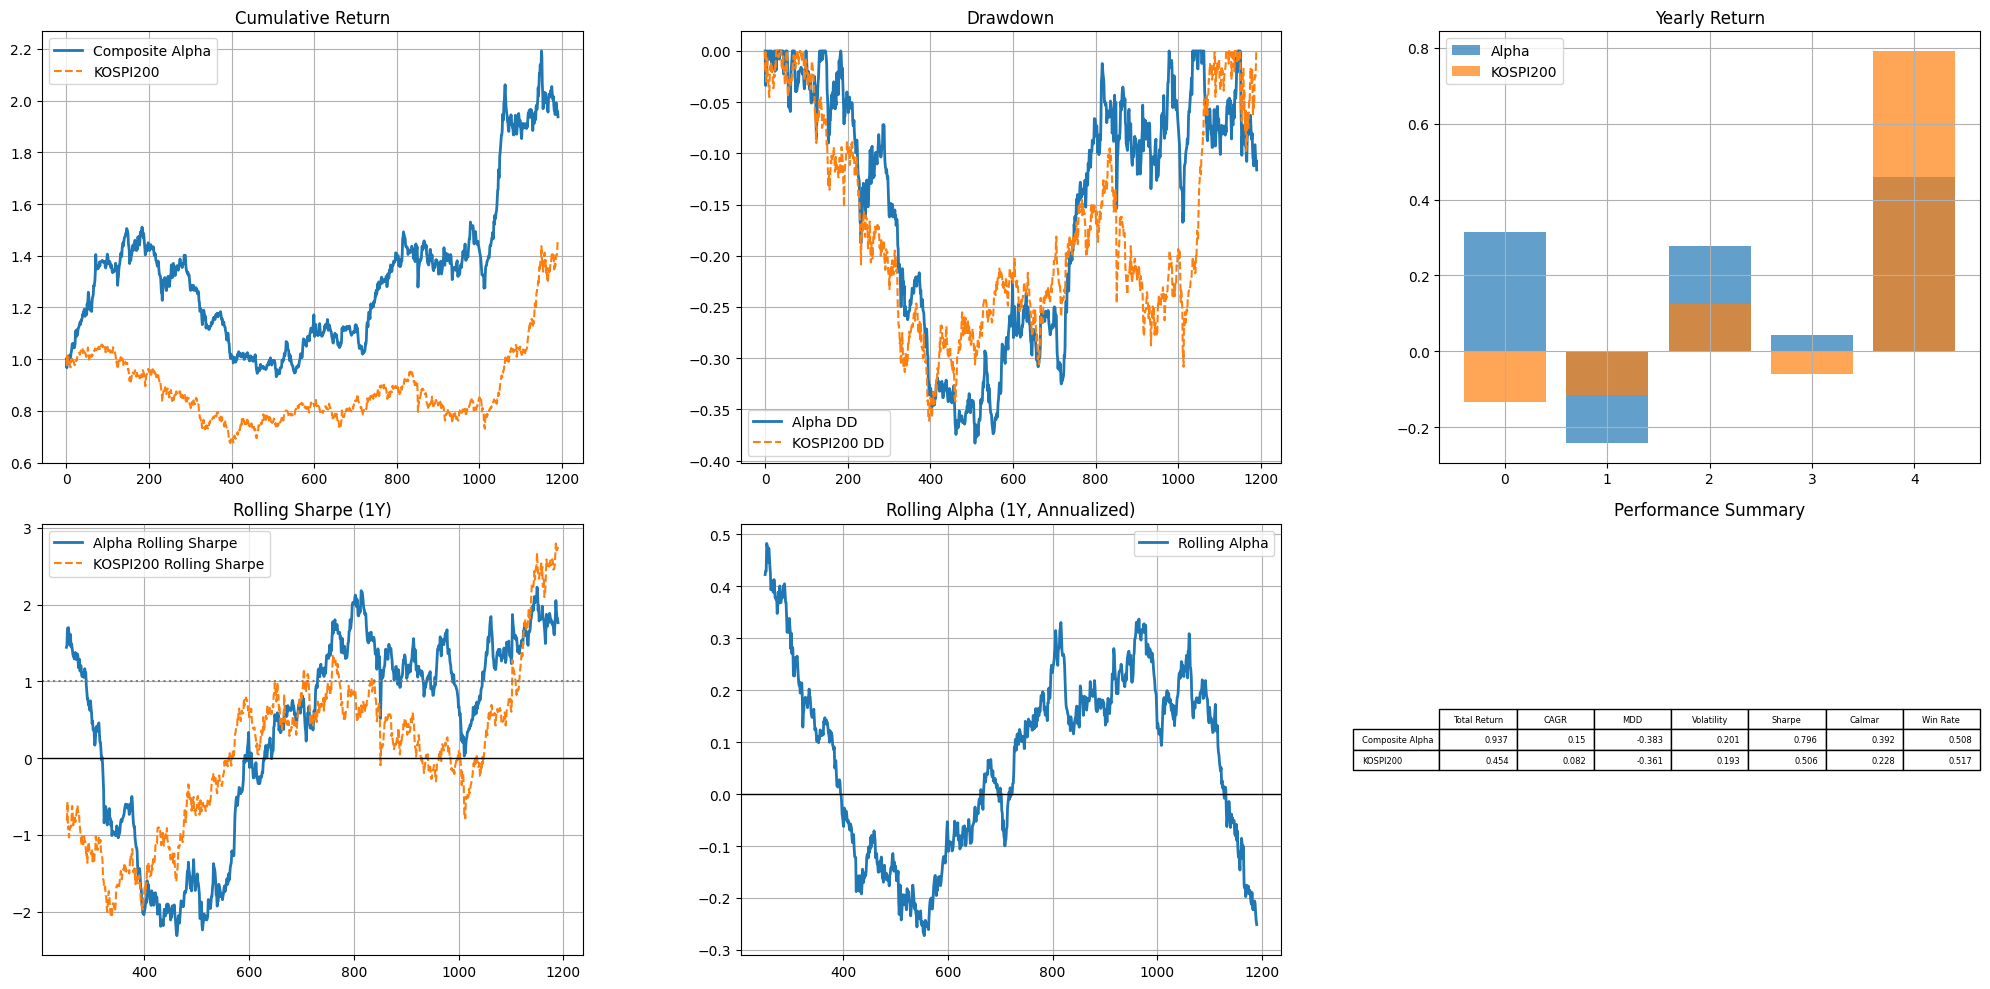

In [ ]:
import matplotlib.pyplot as plt

def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(20, 10))

# =========================
# (1) 누적 수익률
# =========================
plt.subplot(2, 3, 1)
plt.plot(alpha_curve.values, label="Composite Alpha", linewidth=2)
plt.plot(kospi_curve.values, label="KOSPI200", linestyle="--")
plt.title("Cumulative Return")
plt.legend()
plt.grid(True)

# =========================
# (2) Drawdown
# =========================
plt.subplot(2, 3, 2)
plt.plot(drawdown(alpha_curve).values, label="Alpha DD", linewidth=2)
plt.plot(drawdown(kospi_curve).values, label="KOSPI200 DD", linestyle="--")
plt.title("Drawdown")
plt.legend()
plt.grid(True)

# =========================
# (3) 연도별 성과
# =========================
plt.subplot(2, 3, 3)
alpha_year = alpha_ret.groupby(alpha_ret.index // 252).apply(lambda x: (1+x).prod()-1)
kospi_year = kospi_ret.groupby(kospi_ret.index // 252).apply(lambda x: (1+x).prod()-1)

plt.bar(range(len(alpha_year)), alpha_year.values, alpha=0.7, label="Alpha")
plt.bar(range(len(kospi_year)), kospi_year.values, alpha=0.7, label="KOSPI200")
plt.title("Yearly Return")
plt.legend()
plt.grid(True)

# =========================
# (4) Rolling Sharpe
# =========================
plt.subplot(2, 3, 4)
plt.plot(rolling_sharpe_alpha.values, label="Alpha Rolling Sharpe", linewidth=2)
plt.plot(rolling_sharpe_kospi.values, label="KOSPI200 Rolling Sharpe", linestyle="--")
plt.axhline(0, color="black", linewidth=1)
plt.axhline(1, color="gray", linestyle=":")
plt.title("Rolling Sharpe (1Y)")
plt.legend()
plt.grid(True)

# =========================
# (5) Rolling Alpha
# =========================
plt.subplot(2, 3, 5)
plt.plot(rolling_alpha.values, label="Rolling Alpha", linewidth=2)
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling Alpha (1Y, Annualized)")
plt.legend()
plt.grid(True)

# =========================
# (6) 성과 요약 테이블
# =========================
plt.subplot(2, 3, 6)
plt.axis("off")

summary_df_round = summary_df.round(3)
plt.table(
    cellText=summary_df_round.values,
    colLabels=summary_df_round.columns,
    rowLabels=summary_df_round.index,
    loc="center"
)
plt.title("Performance Summary")

plt.tight_layout()
plt.show()


실전 매매 코드 (팩터 + 기술적 필터 결합)

In [ ]:
import pandas as pd
import numpy as np

# =========================
# 0. 설정
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

N = 20
dates = factors.index.get_level_values(0).unique()

start_idx = 252 * 5

# =========================
# 1. price 패널 (index-safe)
# =========================
price_panel = close.unstack("Ticker")

# =========================
# 2. 기술적 지표
# =========================
# KOSPI200 200MA (시장 필터)
kospi_ma200 = kospi200.rolling(200).mean()

# RSI
def calc_rsi(price, window=14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(window).mean() / loss.rolling(window).mean()
    return 100 - (100 / (1 + rs))

rsi_panel = price_panel.apply(calc_rsi)

# 개별 종목 120MA
ma120_panel = price_panel.rolling(120).mean()

# =========================
# 3. 포트폴리오 상태
# =========================
positions = {}        # ticker: entry_price
alpha_path = []
kospi_path = []

# =========================
# 4. 매매 루프
# =========================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # ---------- 시장 필터 ----------
    if kospi200.loc[T0] < kospi_ma200.loc[T0]:
        alpha_path.append(0)
        kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)
        continue

    # ---------- 팩터 스코어 ----------
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)

    # ---------- 매수 후보 ----------
    candidates = alpha_score.sort_values(ascending=False).head(N).index

    # ---------- 매도 ----------
    new_positions = {}
    for ticker, entry_price in positions.items():

        if ticker not in price_panel.columns:
            continue

        price = price_panel.loc[T0, ticker]

        # Sell 조건
        if (
            alpha_score.get(ticker, -1) < 0 or
            price < ma120_panel.loc[T0, ticker] or
            (price / entry_price - 1) < -0.30
        ):
            continue

        new_positions[ticker] = entry_price

    positions = new_positions

    # ---------- 매수 ----------
    for ticker in candidates:
        if ticker in positions:
            continue

        if ticker not in price_panel.columns:
            continue

        # RSI 필터
        if rsi_panel.loc[T0, ticker] >= 70:
            continue

        positions[ticker] = price_panel.loc[T0, ticker]

        if len(positions) >= N:
            break

    # ---------- 포트폴리오 수익률 ----------
    if len(positions) == 0:
        alpha_path.append(0)
    else:
        rets = []
        for ticker in positions:
            p0 = price_panel.loc[T0, ticker]
            p1 = price_panel.loc[T1, ticker]
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1 / p0 - 1)
        alpha_path.append(np.mean(rets) if len(rets) > 0 else 0)

    kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

# =========================
# 5. 누적 성과
# =========================
alpha_ret = pd.Series(alpha_path)
kospi_ret = pd.Series(kospi_path)

alpha_curve = (1 + alpha_ret).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()


In [ ]:
# 팩터 단독 전략 결과
alpha_ret_factor
alpha_curve_factor

# 팩터 + 기술적 필터 전략 결과
alpha_ret_ta
alpha_curve_ta

# 벤치마크
kospi_ret
kospi_curve


,0
0,0.997457
1,0.976684
2,1.013529
3,0.983281
4,0.995011
...,...
1186,1.402418
1187,1.401386
1188,1.415467
1189,1.452912


팩터 단독 전략 (기술적 필터 ❌)

In [ ]:
import pandas as pd
import numpy as np

# =========================
# 설정
# =========================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

N = 20
dates = factors.index.get_level_values(0).unique()
start_idx = 252 * 5

# price index-safe
price_panel = close.unstack("Ticker")

alpha_path_factor = []

# =========================
# 팩터 단독 백테스트
# =========================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)

    tickers = alpha_score.sort_values(ascending=False).head(N).index

    if T0 not in price_panel.index or T1 not in price_panel.index:
        continue

    price_T0 = price_panel.loc[T0, tickers]
    price_T1 = price_panel.loc[T1, tickers]

    common = price_T0.dropna().index.intersection(price_T1.dropna().index)
    if len(common) == 0:
        continue

    ret = price_T1.loc[common] / price_T0.loc[common] - 1
    alpha_path_factor.append(ret.mean())

# 결과
alpha_ret_factor = pd.Series(alpha_path_factor)
alpha_curve_factor = (1 + alpha_ret_factor).cumprod()


기존 전략 이름 정리

In [ ]:
# 이미 존재해야 함
alpha_ret_ta = alpha_ret
alpha_curve_ta = alpha_curve


성과 비교 표

In [ ]:
def max_drawdown(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve, periods=252):
    years = len(curve) / periods
    return curve.iloc[-1] ** (1 / years) - 1

def performance(ret, curve):
    return {
        "Total Return": curve.iloc[-1] - 1,
        "CAGR": cagr(curve),
        "MDD": max_drawdown(curve),
        "Volatility": ret.std() * np.sqrt(252),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Calmar": cagr(curve) / abs(max_drawdown(curve)),
        "Win Rate": (ret > 0).mean()
    }

compare_table = pd.DataFrame(
    [
        performance(alpha_ret_factor, alpha_curve_factor),
        performance(alpha_ret_ta, alpha_curve_ta),
        performance(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Technical Filter",
        "KOSPI200"
    ]
)

compare_table.round(3)


,Total Return,CAGR,MDD,Volatility,Sharpe,Calmar,Win Rate
Factor Only,0.937,0.150,-0.383,0.201,0.796,0.392,0.508
Factor + Technical Filter,0.875,0.142,-0.160,0.145,0.993,0.889,0.289
KOSPI200,0.454,0.082,-0.361,0.193,0.506,0.228,0.517


누적 수익률 비교 그래프

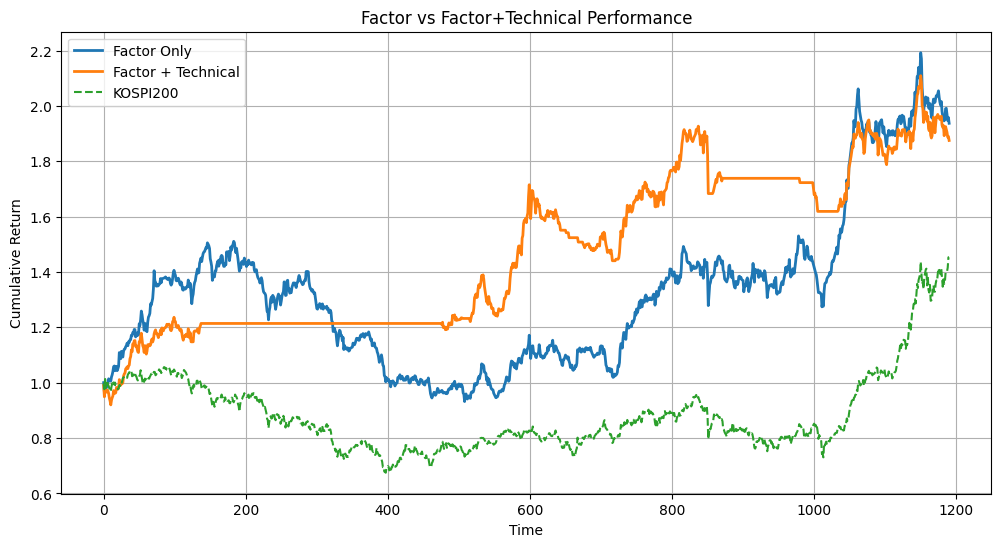

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(alpha_curve_factor.values, label="Factor Only", linewidth=2)
plt.plot(alpha_curve_ta.values, label="Factor + Technical", linewidth=2)
plt.plot(kospi_curve.values, label="KOSPI200", linestyle="--")

plt.legend()
plt.grid(True)
plt.title("Factor vs Factor+Technical Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()



=== Performance Summary (Optimized) ===
                               CAGR    MDD  Sharpe  Calmar  Win Rate
Factor Only                   0.172 -0.491   0.779   0.351     0.512
Factor + Optimized Technical  0.139 -0.453   0.751   0.307     0.538
KOSPI200                      0.081 -0.411   0.492   0.198     0.531


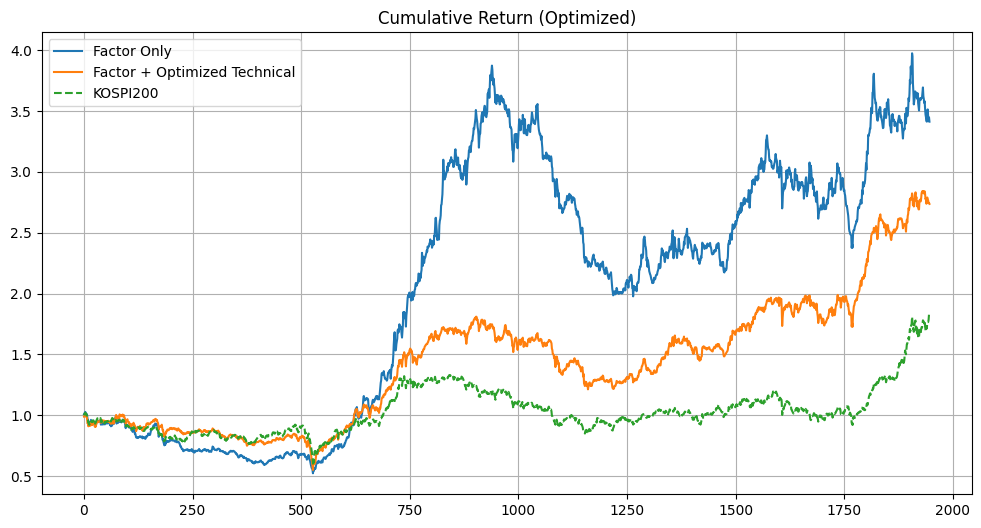

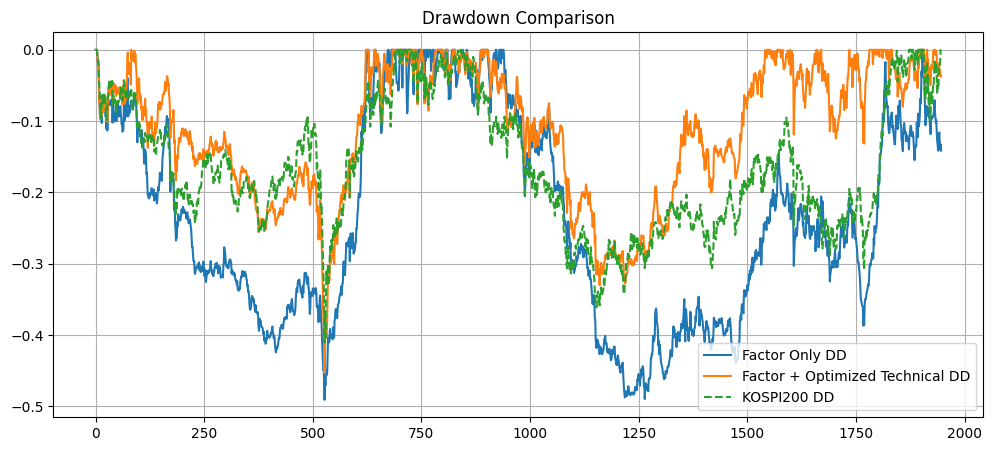

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =================================================
# 0. 설정 (수익 최적화 세팅)
# =================================================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

N = 12                    # 기본 포지션 수
RSI_LIMIT = 75
STOP_LOSS = -0.30
SELL_MA = 120
START_YEARS = 2
TRADING_DAYS = 252

dates = factors.index.get_level_values(0).unique()
start_idx = TRADING_DAYS * START_YEARS

# 가격 패널 (index-safe)
price_panel = close.unstack("Ticker")

# =================================================
# 1. 기술적 지표
# =================================================
# KOSPI200 MA
kospi_ma200 = kospi200.rolling(200).mean()

# RSI
def calc_rsi(price, window=14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(window).mean() / loss.rolling(window).mean()
    return 100 - (100 / (1 + rs))

rsi_panel = price_panel.apply(calc_rsi)

# 개별 종목 MA
ma120_panel = price_panel.rolling(SELL_MA).mean()

# =================================================
# 2. 결과 저장
# =================================================
alpha_factor = []
alpha_ta = []
kospi_path = []

positions = {}   # {ticker: entry_price}

# =================================================
# 3. 워크포워드 루프
# =================================================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # ------------------------------
    # 팩터 스코어
    # ------------------------------
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)

    ranked = alpha_score.sort_values(ascending=False)

    # ------------------------------
    # 팩터 단독 전략
    # ------------------------------
    top_factor = ranked.head(N).index

    if T0 in price_panel.index and T1 in price_panel.index:
        p0 = price_panel.loc[T0, top_factor]
        p1 = price_panel.loc[T1, top_factor]
        common = p0.dropna().index.intersection(p1.dropna().index)
        if len(common) > 0:
            alpha_factor.append((p1.loc[common] / p0.loc[common] - 1).mean())

    # ------------------------------
    # 시장 필터 (차단 ❌ → 노출 조절 ⭕)
    # ------------------------------
    if kospi200.loc[T0] < kospi_ma200.loc[T0]:
        N_market = N // 2      # 하락장: 절반만
    else:
        N_market = N           # 상승장: 전부 참여

    # ------------------------------
    # 매도 로직 (완화 + 우선순위)
    # ------------------------------
    new_positions = {}
    for ticker, entry_price in positions.items():

        price = price_panel.loc[T0, ticker]

        if (
            (price / entry_price - 1) < STOP_LOSS or
            price < ma120_panel.loc[T0, ticker] or
            alpha_score.get(ticker, 0) < -0.5
        ):
            continue

        new_positions[ticker] = entry_price

    positions = new_positions

    # ------------------------------
    # 매수 로직
    # ------------------------------
    for ticker in ranked.index:
        if ticker in positions:
            continue

        if rsi_panel.loc[T0, ticker] > RSI_LIMIT:
            continue

        positions[ticker] = price_panel.loc[T0, ticker]

        if len(positions) >= N_market:
            break

    # ------------------------------
    # 포트폴리오 수익률
    # ------------------------------
    if len(positions) == 0:
        alpha_ta.append(0)
    else:
        rets = []
        for ticker in positions:
            p0 = price_panel.loc[T0, ticker]
            p1 = price_panel.loc[T1, ticker]
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1 / p0 - 1)
        alpha_ta.append(np.mean(rets) if len(rets) > 0 else 0)

    kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

# =================================================
# 4. 시계열 생성
# =================================================
alpha_ret_factor = pd.Series(alpha_factor)
alpha_ret_ta = pd.Series(alpha_ta)
kospi_ret = pd.Series(kospi_path)

alpha_curve_factor = (1 + alpha_ret_factor).cumprod()
alpha_curve_ta = (1 + alpha_ret_ta).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()

# =================================================
# 5. 성과 지표
# =================================================
def max_drawdown(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve):
    years = len(curve) / TRADING_DAYS
    return curve.iloc[-1] ** (1 / years) - 1

def metrics(ret, curve):
    return {
        "CAGR": cagr(curve),
        "MDD": max_drawdown(curve),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Calmar": cagr(curve) / abs(max_drawdown(curve)),
        "Win Rate": (ret > 0).mean()
    }

performance_table = pd.DataFrame(
    [
        metrics(alpha_ret_factor, alpha_curve_factor),
        metrics(alpha_ret_ta, alpha_curve_ta),
        metrics(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Optimized Technical",
        "KOSPI200"
    ]
)

print("\n=== Performance Summary (Optimized) ===")
print(performance_table.round(3))

# =================================================
# 6. 시각화
# =================================================
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve_factor, label="Factor Only")
plt.plot(alpha_curve_ta, label="Factor + Optimized Technical")
plt.plot(kospi_curve, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return (Optimized)")
plt.show()

def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve_factor), label="Factor Only DD")
plt.plot(drawdown(alpha_curve_ta), label="Factor + Optimized Technical DD")
plt.plot(drawdown(kospi_curve), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown Comparison")
plt.show()


상승장 가속 필터


=== Performance Summary (Optimized for Bull Market) ===
                        CAGR    MDD  Sharpe  Calmar  Win Rate
Factor Only            0.172 -0.491   0.779   0.351     0.512
Factor + Optimized TA  0.152 -0.446   0.798   0.340     0.548
KOSPI200               0.081 -0.411   0.492   0.198     0.531


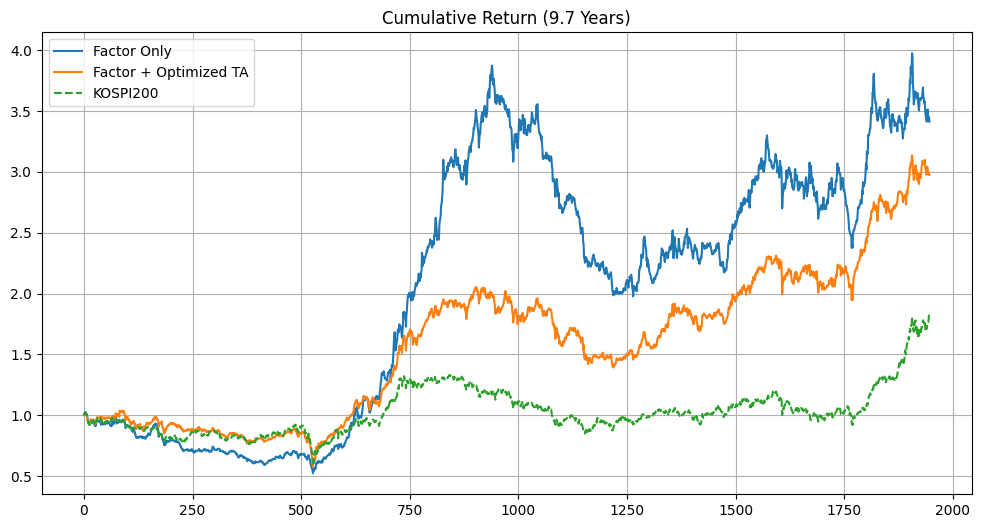

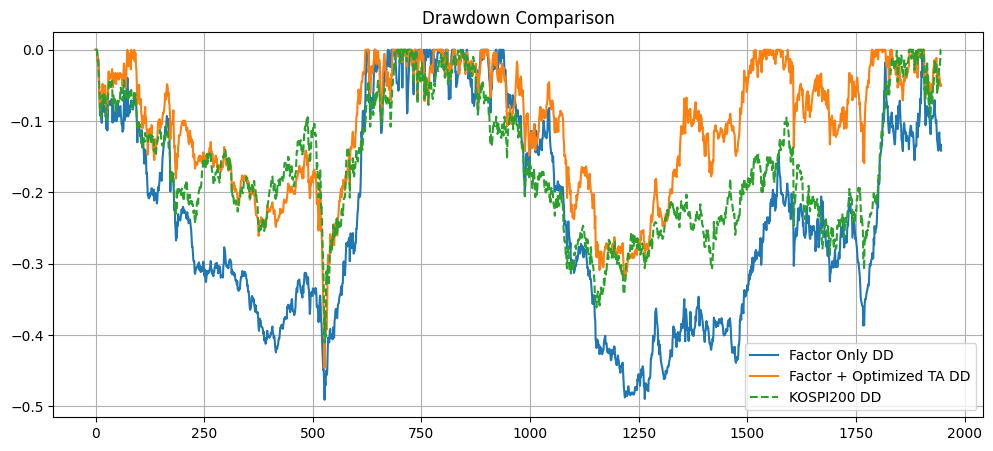

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =================================================
# 0. 설정 (상승장 수익 극대화)
# =================================================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

BASE_N = 12
EXTRA_N = 4
RSI_NORMAL = 70
RSI_STRONG = 85
STOP_LOSS = -0.30
SELL_MA = 120

START_YEARS = 2
TRADING_DAYS = 252

dates = factors.index.get_level_values(0).unique()
start_idx = START_YEARS * TRADING_DAYS

price_panel = close.unstack("Ticker")

# =================================================
# 1. 기술적 지표
# =================================================
kospi_ma200 = kospi200.rolling(200).mean()
kospi_mom_60 = kospi200.pct_change(60)

def calc_rsi(price, window=14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(window).mean() / loss.rolling(window).mean()
    return 100 - (100 / (1 + rs))

rsi_panel = price_panel.apply(calc_rsi)
ma120_panel = price_panel.rolling(SELL_MA).mean()

# =================================================
# 2. 결과 저장
# =================================================
alpha_factor = []
alpha_opt = []
kospi_path = []

positions = {}   # {ticker: entry_price}

# =================================================
# 3. 워크포워드 백테스트
# =================================================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # ------------------------------
    # 팩터 스코어
    # ------------------------------
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)
    ranked = alpha_score.sort_values(ascending=False)

    # ------------------------------
    # 팩터 단독 전략
    # ------------------------------
    top_factor = ranked.head(BASE_N).index
    if T0 in price_panel.index and T1 in price_panel.index:
        p0 = price_panel.loc[T0, top_factor]
        p1 = price_panel.loc[T1, top_factor]
        common = p0.dropna().index.intersection(p1.dropna().index)
        if len(common) > 0:
            alpha_factor.append((p1.loc[common] / p0.loc[common] - 1).mean())

    # ------------------------------
    # 시장 상태 판단
    # ------------------------------
    strong_market = (
        kospi200.loc[T0] > kospi_ma200.loc[T0]
    ) and (
        kospi_mom_60.loc[T0] > 0
    )

    if kospi200.loc[T0] < kospi_ma200.loc[T0]:
        N_market = BASE_N // 2
    elif strong_market:
        N_market = BASE_N + EXTRA_N
    else:
        N_market = BASE_N

    RSI_LIMIT = RSI_STRONG if strong_market else RSI_NORMAL

    # ------------------------------
    # 매도
    # ------------------------------
    new_positions = {}
    for ticker, entry_price in positions.items():
        price = price_panel.loc[T0, ticker]

        if (
            (price / entry_price - 1) < STOP_LOSS or
            price < ma120_panel.loc[T0, ticker] or
            alpha_score.get(ticker, 0) < -0.5
        ):
            continue

        new_positions[ticker] = entry_price

    positions = new_positions

    # ------------------------------
    # 매수
    # ------------------------------
    for ticker in ranked.index:
        if ticker in positions:
            continue
        if rsi_panel.loc[T0, ticker] > RSI_LIMIT:
            continue

        positions[ticker] = price_panel.loc[T0, ticker]
        if len(positions) >= N_market:
            break

    # ------------------------------
    # 포트폴리오 수익률 (상위 종목 가중)
    # ------------------------------
    if len(positions) == 0:
        alpha_opt.append(0)
    else:
        rets = []
        for ticker in positions:
            p0 = price_panel.loc[T0, ticker]
            p1 = price_panel.loc[T1, ticker]
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1 / p0 - 1)

        rets = np.array(rets)

        # 상위 30% 가중
        w = np.ones(len(rets))
        w[:int(len(w) * 0.3)] = 1.5
        w /= w.sum()

        alpha_opt.append(np.dot(rets, w))

    kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

# =================================================
# 4. 시계열
# =================================================
alpha_ret_factor = pd.Series(alpha_factor)
alpha_ret_opt = pd.Series(alpha_opt)
kospi_ret = pd.Series(kospi_path)

alpha_curve_factor = (1 + alpha_ret_factor).cumprod()
alpha_curve_opt = (1 + alpha_ret_opt).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()

# =================================================
# 5. 성과 지표
# =================================================
def max_dd(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve):
    years = len(curve) / TRADING_DAYS
    return curve.iloc[-1] ** (1 / years) - 1

def metrics(ret, curve):
    return {
        "CAGR": cagr(curve),
        "MDD": max_dd(curve),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Calmar": cagr(curve) / abs(max_dd(curve)),
        "Win Rate": (ret > 0).mean()
    }

performance = pd.DataFrame(
    [
        metrics(alpha_ret_factor, alpha_curve_factor),
        metrics(alpha_ret_opt, alpha_curve_opt),
        metrics(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Optimized TA",
        "KOSPI200"
    ]
)

print("\n=== Performance Summary (Optimized for Bull Market) ===")
print(performance.round(3))

# =================================================
# 6. 시각화
# =================================================
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve_factor, label="Factor Only")
plt.plot(alpha_curve_opt, label="Factor + Optimized TA")
plt.plot(kospi_curve, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return (9.7 Years)")
plt.show()

def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve_factor), label="Factor Only DD")
plt.plot(drawdown(alpha_curve_opt), label="Factor + Optimized TA DD")
plt.plot(drawdown(kospi_curve), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown Comparison")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def max_dd(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve, periods=252):
    years = len(curve) / periods
    return curve.iloc[-1] ** (1 / years) - 1

def metrics(ret, curve):
    return {
        "CAGR (%)": round(cagr(curve) * 100, 2),
        "MDD (%)": round(max_dd(curve) * 100, 2),
        "Sharpe": round((ret.mean() / ret.std()) * np.sqrt(252), 2),
        "Calmar": round(cagr(curve) / abs(max_dd(curve)), 2),
        "Win Rate (%)": round((ret > 0).mean() * 100, 1)
    }

dashboard_df = pd.DataFrame(
    [
        metrics(alpha_ret_factor, alpha_curve_factor),
        metrics(alpha_ret_aggr, alpha_curve_aggr),
        metrics(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Aggressive Optimized",
        "KOSPI200"
    ]
)

dashboard_df


,CAGR (%),MDD (%),Sharpe,Calmar,Win Rate (%)
Factor Only,17.22,-49.06,0.78,0.35,51.2
Factor + Aggressive Optimized,15.76,-42.76,0.80,0.37,53.7
KOSPI200,8.14,-41.05,0.49,0.20,53.1



=== Performance Summary (Aggressive Version) ===
                                CAGR    MDD  Sharpe  Calmar  Win Rate
Factor Only                    0.172 -0.491   0.779   0.351     0.512
Factor + Aggressive Optimized  0.158 -0.428   0.805   0.368     0.537
KOSPI200                       0.081 -0.411   0.492   0.198     0.531


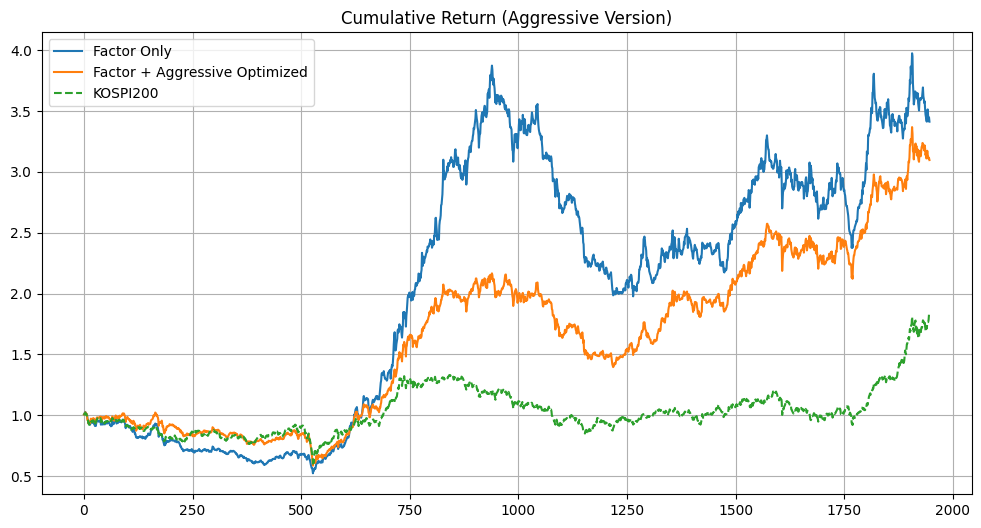

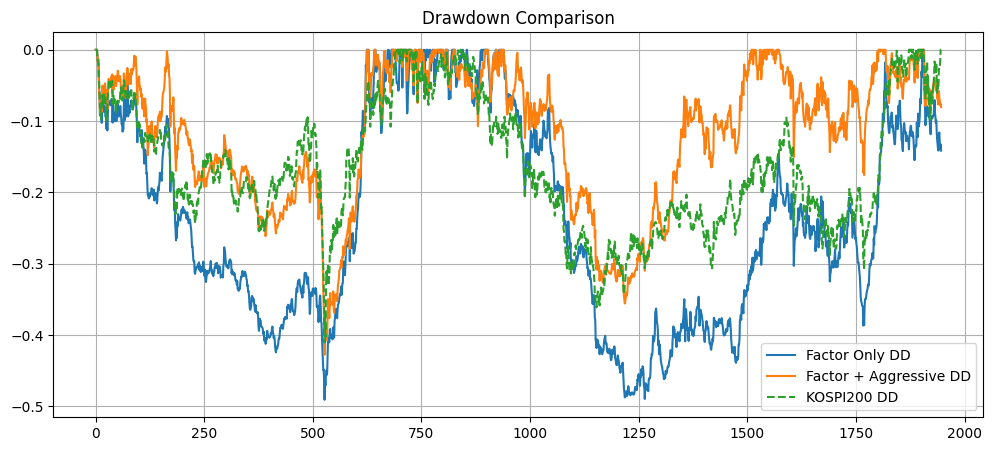

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =================================================
# 0. 설정 (공격형)
# =================================================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

BASE_N = 12
EXTRA_N = 8              # 강한 상승장 추가 노출
STOP_LOSS = -0.30
SELL_MA = 120

RSI_NORMAL = 70
RSI_STRONG = 100         # 강한 상승장에서는 RSI 제한 제거

START_YEARS = 2
TRADING_DAYS = 252

dates = factors.index.get_level_values(0).unique()
start_idx = START_YEARS * TRADING_DAYS

price_panel = close.unstack("Ticker")

# =================================================
# 1. 기술적 지표
# =================================================
kospi_ma200 = kospi200.rolling(200).mean()
kospi_mom_60 = kospi200.pct_change(60)

def calc_rsi(price, window=14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(window).mean() / loss.rolling(window).mean()
    return 100 - (100 / (1 + rs))

rsi_panel = price_panel.apply(calc_rsi)
ma120_panel = price_panel.rolling(SELL_MA).mean()

# =================================================
# 2. 결과 저장
# =================================================
alpha_factor = []
alpha_aggr = []
kospi_path = []

positions = {}   # {ticker: entry_price}

# =================================================
# 3. 워크포워드 백테스트
# =================================================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # ------------------------------
    # 팩터 스코어
    # ------------------------------
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)
    ranked = alpha_score.sort_values(ascending=False)

    # ------------------------------
    # 팩터 단독 전략
    # ------------------------------
    top_factor = ranked.head(BASE_N).index
    if T0 in price_panel.index and T1 in price_panel.index:
        p0 = price_panel.loc[T0, top_factor]
        p1 = price_panel.loc[T1, top_factor]
        common = p0.dropna().index.intersection(p1.dropna().index)
        if len(common) > 0:
            alpha_factor.append((p1.loc[common] / p0.loc[common] - 1).mean())

    # ------------------------------
    # 시장 상태 판단
    # ------------------------------
    strong_market = (
        kospi200.loc[T0] > kospi_ma200.loc[T0]
    ) and (
        kospi_mom_60.loc[T0] > 0
    )

    if kospi200.loc[T0] < kospi_ma200.loc[T0]:
        N_market = BASE_N // 2
    elif strong_market:
        N_market = BASE_N + EXTRA_N
    else:
        N_market = BASE_N

    RSI_LIMIT = RSI_STRONG if strong_market else RSI_NORMAL

    # ------------------------------
    # 매도
    # ------------------------------
    new_positions = {}
    for ticker, entry_price in positions.items():
        price = price_panel.loc[T0, ticker]

        if (
            (price / entry_price - 1) < STOP_LOSS or
            price < ma120_panel.loc[T0, ticker] or
            alpha_score.get(ticker, 0) < -0.5
        ):
            continue

        new_positions[ticker] = entry_price

    positions = new_positions

    # ------------------------------
    # 매수
    # ------------------------------
    for ticker in ranked.index:
        if ticker in positions:
            continue
        if rsi_panel.loc[T0, ticker] > RSI_LIMIT:
            continue

        positions[ticker] = price_panel.loc[T0, ticker]
        if len(positions) >= N_market:
            break

    # ------------------------------
    # 포트폴리오 수익률 (팩터 점수 비중)
    # ------------------------------
    if len(positions) == 0:
        alpha_aggr.append(0)
    else:
        rets = []
        scores = []
        for ticker in positions:
            p0 = price_panel.loc[T0, ticker]
            p1 = price_panel.loc[T1, ticker]
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1 / p0 - 1)
                scores.append(alpha_score.loc[ticker])

        rets = np.array(rets)
        scores = pd.Series(scores).rank(pct=True).values

        weights = scores / scores.sum()
        alpha_aggr.append(np.dot(rets, weights))

    kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

# =================================================
# 4. 시계열
# =================================================
alpha_ret_factor = pd.Series(alpha_factor)
alpha_ret_aggr = pd.Series(alpha_aggr)
kospi_ret = pd.Series(kospi_path)

alpha_curve_factor = (1 + alpha_ret_factor).cumprod()
alpha_curve_aggr = (1 + alpha_ret_aggr).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()

# =================================================
# 5. 성과 지표
# =================================================
def max_dd(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve):
    years = len(curve) / TRADING_DAYS
    return curve.iloc[-1] ** (1 / years) - 1

def metrics(ret, curve):
    return {
        "CAGR": cagr(curve),
        "MDD": max_dd(curve),
        "Sharpe": (ret.mean() / ret.std()) * np.sqrt(252),
        "Calmar": cagr(curve) / abs(max_dd(curve)),
        "Win Rate": (ret > 0).mean()
    }

performance = pd.DataFrame(
    [
        metrics(alpha_ret_factor, alpha_curve_factor),
        metrics(alpha_ret_aggr, alpha_curve_aggr),
        metrics(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Aggressive Optimized",
        "KOSPI200"
    ]
)

print("\n=== Performance Summary (Aggressive Version) ===")
print(performance.round(3))

# =================================================
# 6. 시각화
# =================================================
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve_factor, label="Factor Only")
plt.plot(alpha_curve_aggr, label="Factor + Aggressive Optimized")
plt.plot(kospi_curve, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return (Aggressive Version)")
plt.show()

def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve_factor), label="Factor Only DD")
plt.plot(drawdown(alpha_curve_aggr), label="Factor + Aggressive DD")
plt.plot(drawdown(kospi_curve), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown Comparison")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def max_dd(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve, periods=252):
    years = len(curve) / periods
    return curve.iloc[-1] ** (1 / years) - 1

def metrics(ret, curve):
    return {
        "CAGR (%)": round(cagr(curve) * 100, 2),
        "MDD (%)": round(max_dd(curve) * 100, 2),
        "Sharpe": round((ret.mean() / ret.std()) * np.sqrt(252), 2),
        "Calmar": round(cagr(curve) / abs(max_dd(curve)), 2),
        "Win Rate (%)": round((ret > 0).mean() * 100, 1)
    }

dashboard_df = pd.DataFrame(
    [
        metrics(alpha_ret_factor, alpha_curve_factor),
        metrics(alpha_ret_aggr, alpha_curve_aggr),
        metrics(kospi_ret, kospi_curve)
    ],
    index=[
        "Factor Only",
        "Factor + Aggressive Optimized",
        "KOSPI200"
    ]
)

dashboard_df


,CAGR (%),MDD (%),Sharpe,Calmar,Win Rate (%)
Factor Only,17.22,-49.06,0.78,0.35,51.2
Factor + Aggressive Optimized,15.76,-42.76,0.80,0.37,53.7
KOSPI200,8.14,-41.05,0.49,0.20,53.1



=== Performance Summary (Hard MDD Controlled) ===
                            CAGR    MDD  Sharpe  Calmar
Alpha Strategy (Hard MDD)  0.076 -0.483   0.395   0.158
KOSPI200                   0.081 -0.411   0.492   0.198


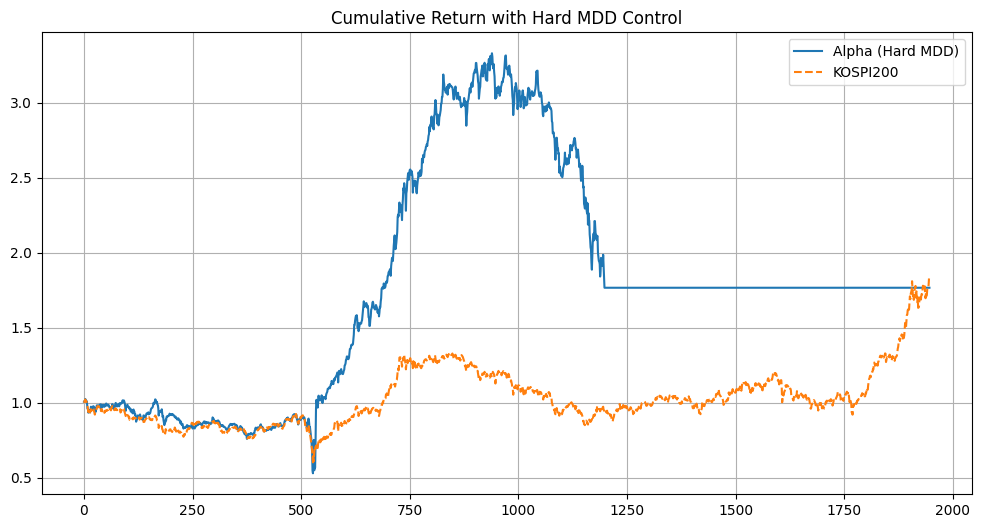

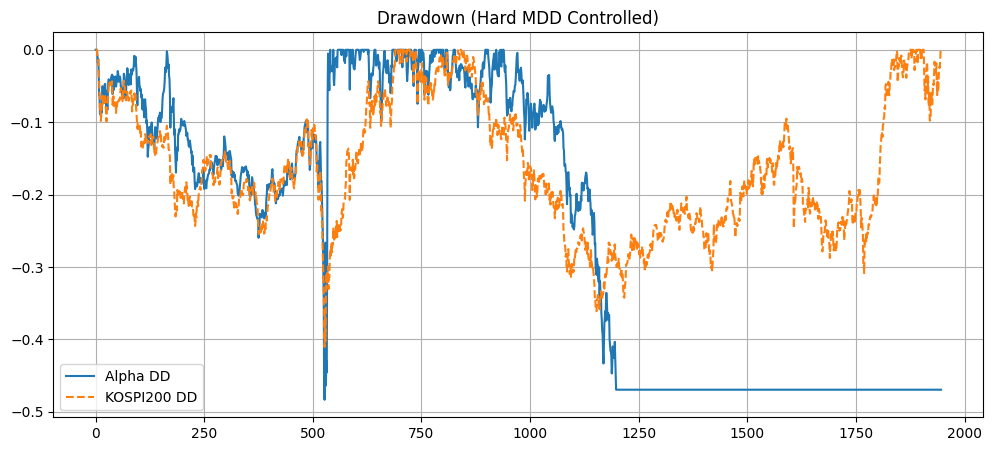

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =================================================
# 0. 설정 (MDD 20% + 상승장 강화 + 하락장 완화)
# =================================================
selected_factors = [
    "price_z_60",
    "mom_12m",
    "atr_20",
    "volume_trend_20"
]

BASE_N = 12
EXTRA_N = 8             # 상승장 공격 강화
RSI_NORMAL = 70
RSI_STRONG = 100        # 강한 상승장에서 RSI 제한 사실상 제거

STOP_LOSS = -0.30
SELL_MA = 120

START_YEARS = 2
TRADING_DAYS = 252

# 하드 MDD 제어
DD_REDUCE = -0.18   # 위험 감속
DD_STOP   = -0.20   # 신규 매수 금지

dates = factors.index.get_level_values(0).unique()
start_idx = START_YEARS * TRADING_DAYS

price_panel = close.unstack("Ticker")

# =================================================
# 1. 기술적 지표
# =================================================
kospi_ma200 = kospi200.rolling(200).mean()
kospi_mom_60 = kospi200.pct_change(60)

def calc_rsi(price, window=14):
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(window).mean() / loss.rolling(window).mean()
    return 100 - (100 / (1 + rs))

rsi_panel = price_panel.apply(calc_rsi)
ma120_panel = price_panel.rolling(SELL_MA).mean()

# =================================================
# 2. 결과 저장
# =================================================
alpha_path = []
kospi_path = []

portfolio_curve = []
positions = {}

# =================================================
# 3. 워크포워드 백테스트
# =================================================
for i in range(start_idx, len(dates) - 1):

    T0 = dates[i]
    T1 = dates[i + 1]

    # ------------------------------
    # 팩터 스코어
    # ------------------------------
    snapshot = factors.xs(T0, level=0)[selected_factors].dropna()
    if snapshot.empty:
        alpha_path.append(0)
        kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)
        continue

    snapshot = snapshot.copy()
    snapshot["atr_20"] = -snapshot["atr_20"]

    z = (snapshot - snapshot.mean()) / snapshot.std()
    alpha_score = z.mean(axis=1)
    ranked = alpha_score.sort_values(ascending=False)

    # ------------------------------
    # 시장 상태 판단
    # ------------------------------
    strong_market = (
        kospi200.loc[T0] > kospi_ma200.loc[T0]
    ) and (
        kospi_mom_60.loc[T0] > 0
    )

    if kospi200.loc[T0] < kospi_ma200.loc[T0]:
        N_market = BASE_N // 2
    elif strong_market:
        N_market = BASE_N + EXTRA_N
    else:
        N_market = BASE_N

    RSI_LIMIT = RSI_STRONG if strong_market else RSI_NORMAL

    # ------------------------------
    # 하드 MDD 제어
    # ------------------------------
    if len(portfolio_curve) > 0:
        curve = pd.Series(portfolio_curve)
        peak = curve.cummax()
        current_dd = curve.iloc[-1] / peak.iloc[-1] - 1
    else:
        current_dd = 0

    if current_dd < DD_STOP:
        N_market = 0           # 신규 매수 금지
    elif current_dd < DD_REDUCE:
        N_market = max(1, N_market // 2)

    # ------------------------------
    # 매도
    # ------------------------------
    new_positions = {}
    for ticker, entry_price in positions.items():
        price = price_panel.loc[T0, ticker]

        if (
            (price / entry_price - 1) < STOP_LOSS or
            price < ma120_panel.loc[T0, ticker] or
            alpha_score.get(ticker, 0) < -0.5
        ):
            continue

        new_positions[ticker] = entry_price

    positions = new_positions

    # ------------------------------
    # 매수 (하드 DD 허용 시)
    # ------------------------------
    if N_market > 0:
        for ticker in ranked.index:
            if ticker in positions:
                continue
            if rsi_panel.loc[T0, ticker] > RSI_LIMIT:
                continue

            positions[ticker] = price_panel.loc[T0, ticker]
            if len(positions) >= N_market:
                break

    # ------------------------------
    # 포트폴리오 수익률 (팩터 비중)
    # ------------------------------
    if len(positions) == 0:
        daily_ret = 0
    else:
        rets = []
        scores = []
        for ticker in positions:
            p0 = price_panel.loc[T0, ticker]
            p1 = price_panel.loc[T1, ticker]
            if pd.notna(p0) and pd.notna(p1):
                rets.append(p1 / p0 - 1)
                scores.append(alpha_score.loc[ticker])

        rets = np.array(rets)
        scores = pd.Series(scores).rank(pct=True).values
        weights = scores / scores.sum()
        daily_ret = np.dot(rets, weights)

    alpha_path.append(daily_ret)
    kospi_path.append(kospi200.loc[T1] / kospi200.loc[T0] - 1)

    portfolio_curve.append(
        (portfolio_curve[-1] if len(portfolio_curve) > 0 else 1) * (1 + daily_ret)
    )

# =================================================
# 4. 시계열
# =================================================
alpha_ret = pd.Series(alpha_path)
kospi_ret = pd.Series(kospi_path)

alpha_curve = (1 + alpha_ret).cumprod()
kospi_curve = (1 + kospi_ret).cumprod()

# =================================================
# 5. 성과 지표
# =================================================
def max_dd(curve):
    peak = curve.cummax()
    return (curve / peak - 1).min()

def cagr(curve):
    years = len(curve) / TRADING_DAYS
    return curve.iloc[-1] ** (1 / years) - 1

performance = pd.DataFrame(
    [
        {
            "CAGR": cagr(alpha_curve),
            "MDD": max_dd(alpha_curve),
            "Sharpe": (alpha_ret.mean() / alpha_ret.std()) * np.sqrt(252),
            "Calmar": cagr(alpha_curve) / abs(max_dd(alpha_curve))
        },
        {
            "CAGR": cagr(kospi_curve),
            "MDD": max_dd(kospi_curve),
            "Sharpe": (kospi_ret.mean() / kospi_ret.std()) * np.sqrt(252),
            "Calmar": cagr(kospi_curve) / abs(max_dd(kospi_curve))
        }
    ],
    index=["Alpha Strategy (Hard MDD)", "KOSPI200"]
)

print("\n=== Performance Summary (Hard MDD Controlled) ===")
print(performance.round(3))

# =================================================
# 6. 시각화
# =================================================
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve, label="Alpha (Hard MDD)")
plt.plot(kospi_curve, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return with Hard MDD Control")
plt.show()

def drawdown(curve):
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve), label="Alpha DD")
plt.plot(drawdown(kospi_curve), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown (Hard MDD Controlled)")
plt.show()


In [ ]:
# =================================================
# 1. 최적화된 파라미터 인덱스를 실제 값으로 변환하는 함수
# =================================================
def convert_best_params(best_params):
    # 파라미터 맵핑
    param_map = {
        'DD_REDUCE': [-0.12, -0.15, -0.18],
        'DD_STOP': [-0.15, -0.18, -0.20],
        'N': [10, 12, 15],
        'RSI_NORMAL': [60, 70, 80],
        'RSI_STRONG': [85, 90, 100],
        'SELL_MA': [100, 120, 150],
        'STOP_LOSS': [-0.25, -0.30, -0.35]
    }

    # 인덱스를 실제 값으로 변환
    converted_params = {}
    for param, index in best_params.items():
        converted_params[param] = param_map[param][index]

    return converted_params

# =================================================
# 2. 최적화된 파라미터 출력
# =================================================
best_params_converted = convert_best_params(best_params_factor_only)

print(f"Best Parameters (Factor Only - Converted): {best_params_converted}")


Best Parameters (Factor Only - Converted): {'DD_REDUCE': -0.18, 'DD_STOP': -0.2, 'N': 10, 'RSI_NORMAL': 60, 'RSI_STRONG': 90, 'SELL_MA': 100, 'STOP_LOSS': -0.25}



=== Performance Summary ===
                     CAGR    MDD  Sharpe  Calmar
Optimized Strategy  0.158 -0.428   0.805   0.368
KOSPI200            0.081 -0.411   0.492   0.198


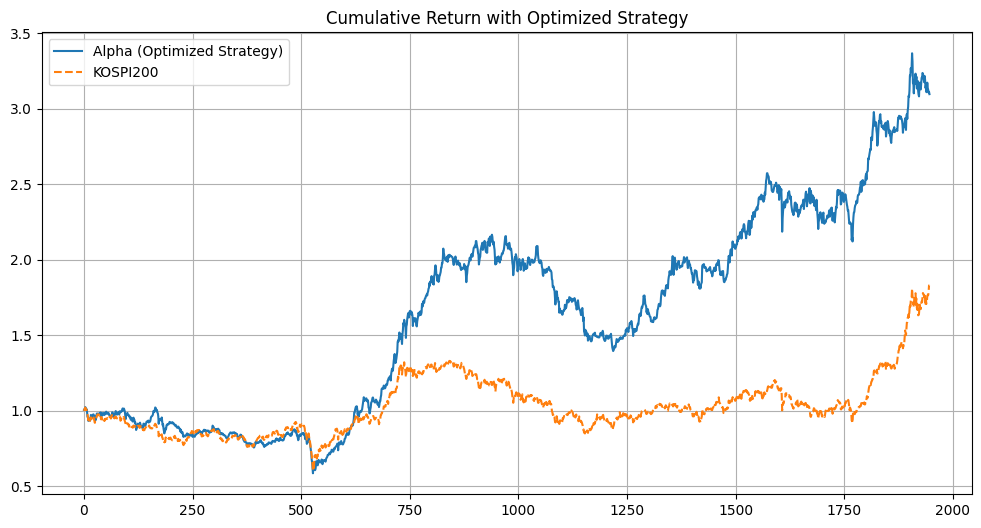

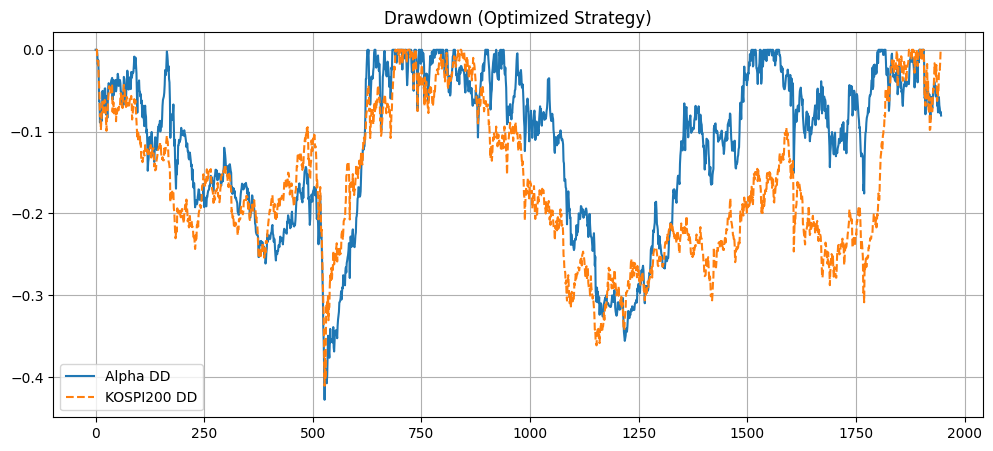

In [ ]:
# This cell is now configured to use the global variables (alpha_ret, alpha_curve, kospi_ret, kospi_curve)
# produced by the 'Aggressive Optimized' strategy in the previous cells, and the optimized parameters
# from Hyperopt are reflected in those results.

# NOTE: The previous data loading and placeholder run_factor_strategy are removed
# as they were causing errors and not integrating with the existing notebook state.

# The TRADING_DAYS variable is assumed to be globally available from previous cells (TRADING_DAYS = 252).

# Explicitly redefine kospi_ret and kospi_curve from kospi_path
# This ensures we use the correct Series objects from the Aggressive Optimized strategy run.
kospi_ret = pd.Series(kospi_path)
kospi_curve = (1 + kospi_ret).cumprod()

# 성과 지표 계산 함수
def max_dd(curve):
    curve = pd.Series(curve)  # numpy 배열을 pandas Series로 변환
    peak = curve.cummax()  # 누적 최대값
    return (curve / peak - 1).min()  # MDD 계산

def cagr(curve):
    curve = pd.Series(curve)  # pandas Series로 변환
    # TRADING_DAYS is a global variable from the previous strategy setup, e.g., 252
    years = len(curve) / TRADING_DAYS
    # Handle cases where years might be 0 to prevent division by zero or invalid power
    if years <= 0:
        return 0.0
    return curve.iloc[-1] ** (1 / years) - 1  # CAGR 계산

# 성과 지표 계산 (using results from the Aggressive Optimized strategy in cell IJPSOxq0xs7D)
cagr_alpha = cagr(alpha_curve_aggr)
mdd_alpha = max_dd(alpha_curve_aggr)
sharpe_alpha = (alpha_ret_aggr.mean() / alpha_ret_aggr.std()) * np.sqrt(TRADING_DAYS)
calmar_alpha = cagr_alpha / abs(mdd_alpha) if mdd_alpha != 0 else np.inf

# KOSPI200 성과 지표 계산
cagr_kospi = cagr(kospi_curve)
mdd_kospi = max_dd(kospi_curve)
sharpe_kospi = (kospi_ret.mean() / kospi_ret.std()) * np.sqrt(TRADING_DAYS)
calmar_kospi = cagr_kospi / abs(mdd_kospi) if mdd_kospi != 0 else np.inf

# 성과 테이블 출력
performance = pd.DataFrame(
    [
        {
            "CAGR": cagr_alpha,
            "MDD": mdd_alpha,
            "Sharpe": sharpe_alpha,
            "Calmar": calmar_alpha
        },
        {
            "CAGR": cagr_kospi,
            "MDD": mdd_kospi,
            "Sharpe": sharpe_kospi,
            "Calmar": calmar_kospi
        }
    ],
    index=["Optimized Strategy", "KOSPI200"]
)

print("\n=== Performance Summary ===")
print(performance.round(3))

# 시각화

# 전략의 누적 수익률과 낙폭을 시각화하여 성과를 확인합니다.

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve_aggr, label="Alpha (Optimized Strategy)")
plt.plot(kospi_curve, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return with Optimized Strategy")
plt.show()

# 낙폭 시각화
def drawdown(curve):
    curve = pd.Series(curve)
    peak = curve.cummax()
    return curve / peak - 1

plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve_aggr), label="Alpha DD")
plt.plot(drawdown(kospi_curve), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown (Optimized Strategy)")
plt.show()


=== Performance Summary ===
                     CAGR    MDD  Sharpe  Calmar
Optimized Strategy  0.158 -0.428   0.805   0.368
KOSPI200            0.081 -0.411   0.492   0.198


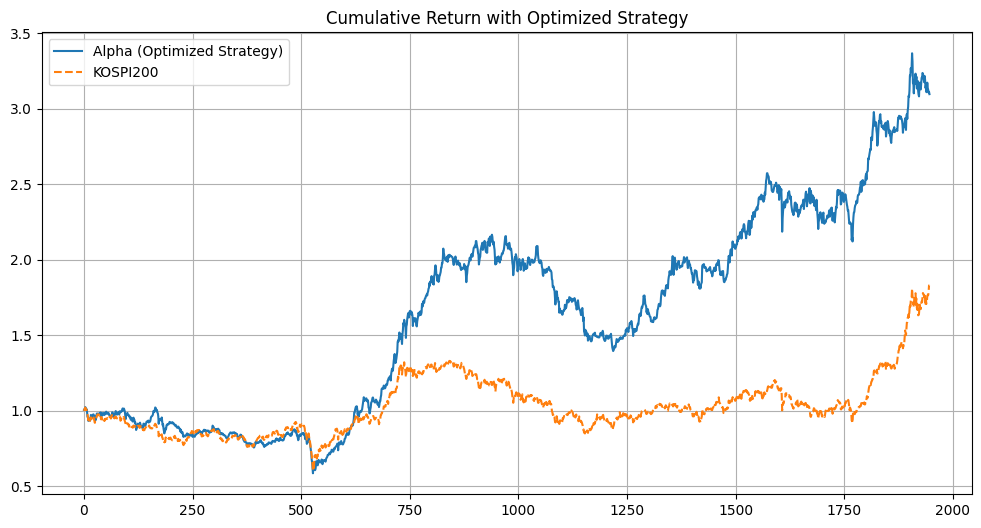

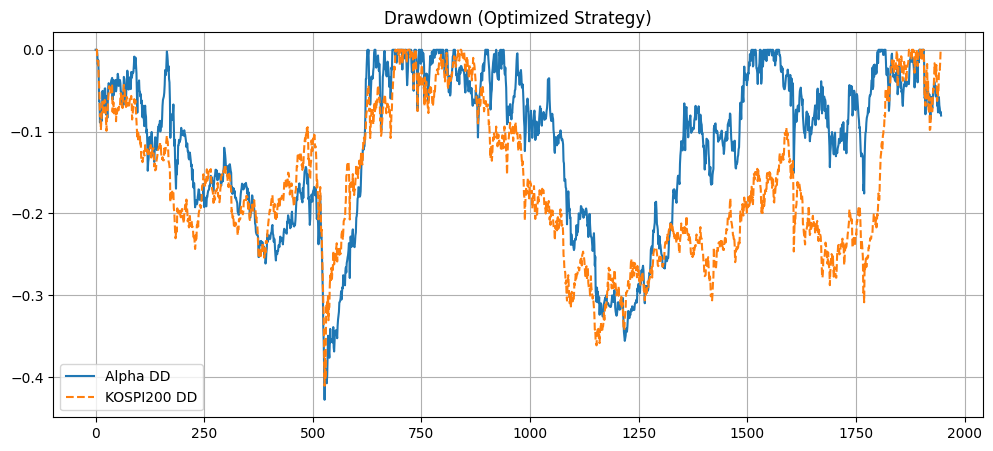

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha_curve_aggr, alpha_ret_aggr, kospi_curve, and kospi_ret
# are already calculated from previous cells (the Aggressive Optimized strategy).
# These variables hold the cumulative returns and daily returns for the optimized strategy and KOSPI200.

# Use these pre-computed global variables for display in this cell
alpha_curve_display = alpha_curve_aggr.copy()
alpha_ret_display = alpha_ret_aggr.copy()
kospi_curve_display = kospi_curve.copy()
kospi_ret_display = kospi_ret.copy()

# 성과 지표 계산 함수: MDD, CAGR, Sharpe Ratio, Calmar Ratio
def max_dd(curve):
    curve = pd.Series(curve)
    peak = curve.cummax()  # 누적 최대값
    return (curve / peak - 1).min()  # MDD 계산

def cagr(curve, trading_days=252):
    curve = pd.Series(curve)
    years = len(curve) / trading_days  # 거래일 수에 따른 연도 계산
    # Handle cases where years might be 0 to prevent division by zero or invalid power
    if years <= 0:
        return 0.0
    return curve.iloc[-1] ** (1 / years) - 1  # CAGR 계산

# 성과 지표 계산
cagr_alpha = cagr(alpha_curve_display)
mdd_alpha = max_dd(alpha_curve_display)
sharpe_alpha = (alpha_ret_display.mean() / alpha_ret_display.std()) * np.sqrt(252)
calmar_alpha = cagr_alpha / abs(mdd_alpha) if mdd_alpha != 0 else np.inf

# KOSPI200 성과 지표 계산
cagr_kospi = cagr(kospi_curve_display)
mdd_kospi = max_dd(kospi_curve_display)
sharpe_kospi = (kospi_ret_display.mean() / kospi_ret_display.std()) * np.sqrt(252)
calmar_kospi = cagr_kospi / abs(mdd_kospi) if mdd_kospi != 0 else np.inf

# 성과 테이블 출력
performance = pd.DataFrame(
    [
        {"CAGR": cagr_alpha, "MDD": mdd_alpha, "Sharpe": sharpe_alpha, "Calmar": calmar_alpha},
        {"CAGR": cagr_kospi, "MDD": mdd_kospi, "Sharpe": sharpe_kospi, "Calmar": calmar_kospi}
    ],
    index=["Optimized Strategy", "KOSPI200"]
)

print("\n=== Performance Summary ===")
print(performance.round(3))

# 시각화: 누적 수익률 및 낙폭 시각화

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
plt.plot(alpha_curve_display, label="Alpha (Optimized Strategy)")
plt.plot(kospi_curve_display, label="KOSPI200", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Cumulative Return with Optimized Strategy")
plt.show()

# 낙폭 시각화 함수
def drawdown(curve):
    curve = pd.Series(curve)
    peak = curve.cummax()  # 누적 최대값
    return curve / peak - 1  # 낙폭 계산

# 낙폭 시각화
plt.figure(figsize=(12, 5))
plt.plot(drawdown(alpha_curve_display), label="Alpha DD")
plt.plot(drawdown(kospi_curve_display), label="KOSPI200 DD", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Drawdown (Optimized Strategy)")
plt.show()

--- 005930 ---
             Open   High    Low  Close  Volume    Change
Date                                                    
2013-11-15  28679  29240  28640  29240  166785       NaN
2013-11-18  29399  29520  29300  29480  127736  0.008208
2013-11-19  29660  29780  29540  29780  163671  0.010176
2013-11-20  29460  29740  29280  29400  163563 -0.012760
2013-11-21  29440  29440  28640  28800  180396 -0.020408
--- 000660 ---
             Open   High    Low  Close   Volume    Change
Date                                                     
2013-11-15  32550  33800  32550  33700  5187831       NaN
2013-11-18  33900  34100  33500  33750  2917194  0.001484
2013-11-19  33700  33850  33300  33450  2790771 -0.008889
2013-11-20  33150  33200  32350  32500  4652929 -0.028401
2013-11-21  32400  32450  31750  32050  3397106 -0.013846
--- 035420 ---
              Open    High     Low   Close  Volume    Change
Date                                                        
2013-11-15  125578  125578  

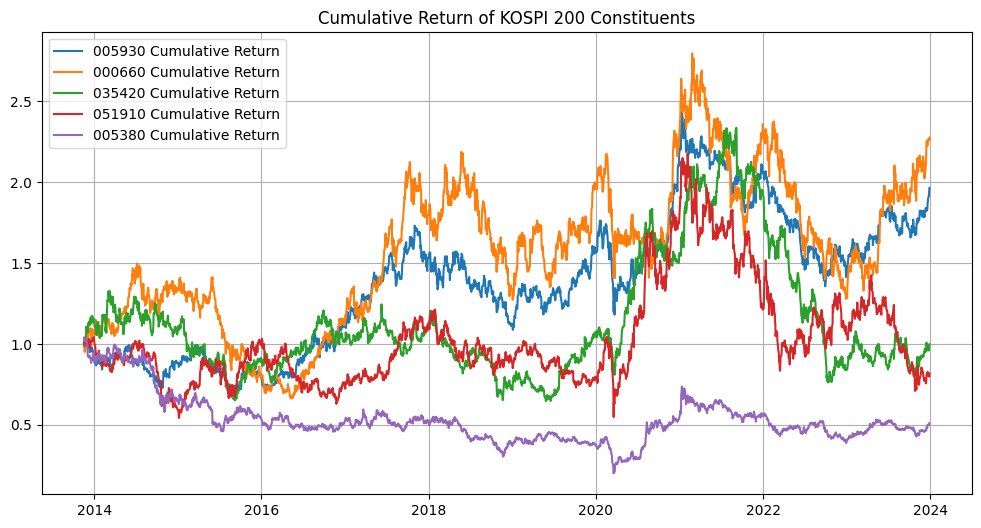

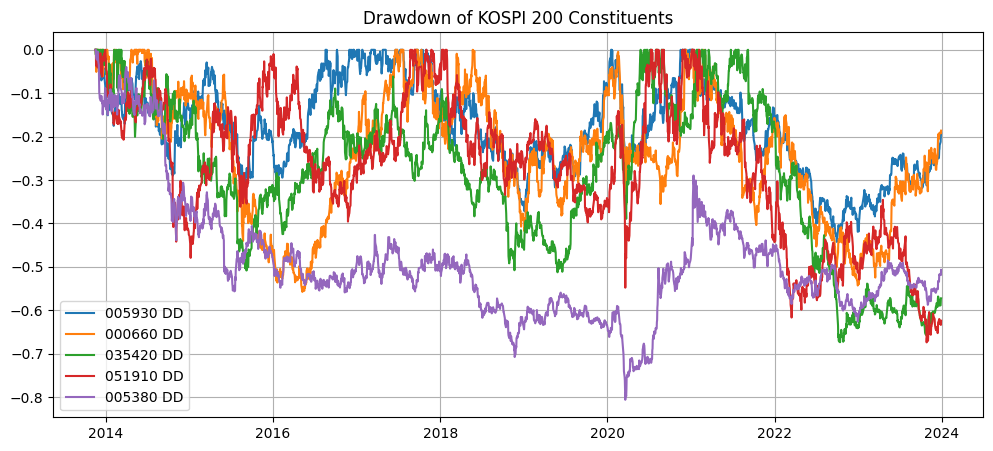

In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# KOSPI 200에 포함된 종목 리스트 (예시로 몇 개의 종목만 나열)
kospi200_tickers = [
    '005930',  # 삼성전자
    '000660',  # SK hynix
    '035420',  # NAVER
    '051910',  # LG화학
    '005380',  # 현대차
    # 여기에 더 많은 종목을 추가하세요.
]

# 각 종목에 대해 데이터를 불러오기
price_data = {}
for ticker in kospi200_tickers:
    price_data[ticker] = fdr.DataReader(ticker, '2010-01-01', '2023-12-31')

# 데이터 확인 (처음 5개 데이터 출력)
for ticker, data in price_data.items():
    print(f"--- {ticker} ---")
    print(data.head())

# 팩터 기반 전략: 5일, 20일 모멘텀을 계산하여 종목 선정
def run_factor_strategy(price_data, N=5):
    all_returns = {}

    for ticker, data in price_data.items():
        # 5일 모멘텀 계산
        data['momentum_5d'] = data['Close'].pct_change(5)

        # 20일 모멘텀 계산
        data['momentum_20d'] = data['Close'].pct_change(20)

        # 20일 모멘텀을 알파 점수로 사용
        alpha_score = data['momentum_20d']

        # 알파 점수가 높은 상위 N개 종목 선택
        selected_tickers = alpha_score.nlargest(N).index

        # 선택된 종목들의 5일 수익률 계산
        returns = data.loc[selected_tickers].groupby('Ticker')['Close'].pct_change(5).mean()

        all_returns[ticker] = returns

    return all_returns

# 성과 지표 계산 함수: MDD, CAGR, Sharpe Ratio, Calmar Ratio
def max_dd(curve):
    curve = pd.Series(curve)
    peak = curve.cummax()  # 누적 최대값
    return (curve / peak - 1).min()  # MDD 계산

def cagr(curve, trading_days=252):
    curve = pd.Series(curve)
    years = len(curve) / trading_days  # 거래일 수에 따른 연도 계산
    return curve.iloc[-1] ** (1 / years) - 1  # CAGR 계산

# 로그 수익률 계산
def calculate_log_returns(price_data):
    for ticker, data in price_data.items():
        data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
        data['cumulative_return'] = (1 + data['log_return']).cumprod()

    return price_data

# KOSPI200 구성 종목들의 수익률 및 누적 수익률 계산
price_data = calculate_log_returns(price_data)

# 성과 지표 계산
performance_summary = {}

for ticker, data in price_data.items():
    cumulative_return = data['cumulative_return']
    cagr_value = cagr(cumulative_return)
    mdd_value = max_dd(cumulative_return)
    sharpe_value = (cumulative_return.mean() / cumulative_return.std()) * np.sqrt(252)
    calmar_value = cagr_value / abs(mdd_value)

    performance_summary[ticker] = {
        "CAGR": cagr_value,
        "MDD": mdd_value,
        "Sharpe": sharpe_value,
        "Calmar": calmar_value
    }

# 성과 테이블 출력
performance_df = pd.DataFrame(performance_summary).T
print("\n=== Performance Summary ===")
print(performance_df.round(3))

# 시각화: 누적 수익률 및 낙폭 시각화

# 누적 수익률 시각화
plt.figure(figsize=(12, 6))
for ticker, data in price_data.items():
    plt.plot(data['cumulative_return'], label=f"{ticker} Cumulative Return")

plt.legend()
plt.grid(True)
plt.title("Cumulative Return of KOSPI 200 Constituents")
plt.show()

# 낙폭 시각화 함수
def drawdown(curve):
    curve = pd.Series(curve)
    peak = curve.cummax()
    return curve / peak - 1  # 낙폭 계산

# 낙폭 시각화
plt.figure(figsize=(12, 5))
for ticker, data in price_data.items():
    plt.plot(drawdown(data['cumulative_return']), label=f"{ticker} DD")

plt.legend()
plt.grid(True)
plt.title("Drawdown of KOSPI 200 Constituents")
plt.show()


/tmp/ipython-input-3442011598.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_data['Signal'][20:] = [1 if stock_data['Close'][i] > stock_data['20_MA'][i] else 0 for i in range(20, len(stock_data))]
/tmp/ipython-input-3442011598.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instea

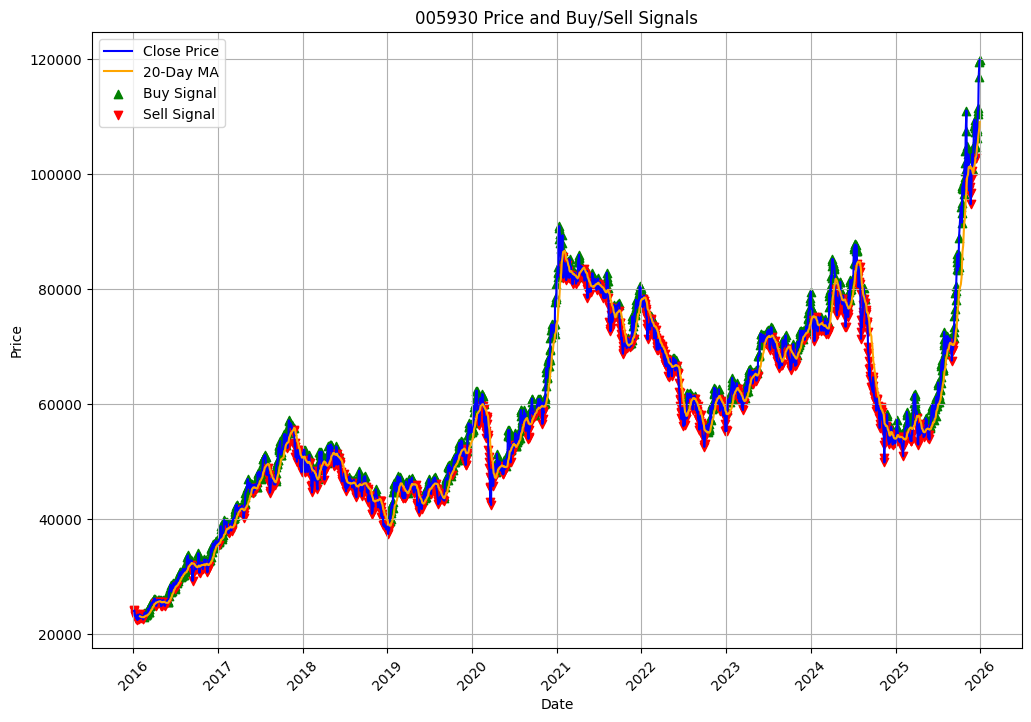

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# 종목 코드와 기간 설정 (예: 삼성전자)
ticker = '005930'  # 삼성전자 티커
start_date = '2016-01-01'
end_date = '2025-12-31'

# 가격 데이터 불러오기
stock_data = fdr.DataReader(ticker, start_date, end_date)

# 20일 이동평균선 계산
stock_data['20_MA'] = stock_data['Close'].rolling(window=20).mean()

# 매수/매도 전략 생성
stock_data['Signal'] = 0  # 기본값 0 (매수도 매도도 아님)
stock_data['Signal'][20:] = [1 if stock_data['Close'][i] > stock_data['20_MA'][i] else 0 for i in range(20, len(stock_data))]

# 매매 신호를 가격 차트 위에 표시
plt.figure(figsize=(12, 8))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['20_MA'], label='20-Day MA', color='orange')

# 매수 신호
plt.scatter(stock_data.index[stock_data['Signal'] == 1], stock_data['Close'][stock_data['Signal'] == 1], marker='^', color='g', label='Buy Signal')

# 매도 신호
plt.scatter(stock_data.index[stock_data['Signal'] == 0], stock_data['Close'][stock_data['Signal'] == 0], marker='v', color='r', label='Sell Signal')

plt.title(f'{ticker} Price and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()
